**Download and Load all S&P500 stock prices data**

In [ ]:
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import matplotlib.pyplot as plt
import statsmodels.api as sm
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import pandas_ta
import requests
import warnings
warnings.filterwarnings('ignore')


In [ ]:
# Fetch S&P 500 companies table from Wikipedia with proper headers
url = 'https://en.wikipedia.org/wiki/List_of_S%26P_500_companies'
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36',
    'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,*/*;q=0.8',
    'Accept-Language': 'en-US,en;q=0.5',
    'Accept-Encoding': 'gzip, deflate',
    'Connection': 'keep-alive',
}

try:
    response = requests.get(url, headers=headers, timeout=10)
    response.raise_for_status()  # Raise an error for bad status codes
    
    # Read all tables from the page
    tables = pd.read_html(response.text)
    print(f"Found {len(tables)} table(s) on the page")
    
    # Find the table with S&P 500 companies (should have 'Symbol' column and many rows)
    sp500 = None
    for i, table in enumerate(tables):
        # Check if this looks like the S&P 500 companies table
        if 'Symbol' in table.columns and len(table) > 100:
            sp500 = table
            print(f"Using table {i} with {len(sp500)} companies")
            print(f"Columns: {list(sp500.columns)}")
            break
    
    if sp500 is None:
        # If not found by criteria, try the first large table
        for i, table in enumerate(tables):
            if len(table) > 100:
                sp500 = table
                print(f"Using table {i} (largest table) with {len(sp500)} rows")
                print(f"Columns: {list(sp500.columns)}")
                break
    
    if sp500 is None:
        # Last resort: use the first table
        sp500 = tables[0]
        print(f"Using first table with {len(sp500)} rows")
        print(f"Columns: {list(sp500.columns)}")
        
except requests.exceptions.RequestException as e:
    print(f"Error fetching data: {e}")
    raise

sp500

Found 3 table(s) on the page
Using table 1 with 503 companies
Columns: ['Symbol', 'Security', 'GICS Sector', 'GICS Sub-Industry', 'Headquarters Location', 'Date added', 'CIK', 'Founded']


Symbol             Security             GICS Sector  \
0      MMM                   3M             Industrials   
1      AOS          A. O. Smith             Industrials   
2      ABT  Abbott Laboratories             Health Care   
3     ABBV               AbbVie             Health Care   
4      ACN            Accenture  Information Technology   
..     ...                  ...                     ...   
498    XYL           Xylem Inc.             Industrials   
499    YUM          Yum! Brands  Consumer Discretionary   
500   ZBRA   Zebra Technologies  Information Technology   
501    ZBH        Zimmer Biomet             Health Care   
502    ZTS               Zoetis             Health Care   

                                GICS Sub-Industry    Headquarters Location  \
0                        Industrial Conglomerates    Saint Paul, Minnesota   
1                               Building Products     Milwaukee, Wisconsin   
2                           Health Care Equipment  North Chicago, Illinois   
3                                   Biotechnology  North Chicago, Illinois   
4                  IT Consulting & Other Services          Dublin, Ireland   
..                                            ...                      ...   
498  Industrial Machinery & Supplies & Components   White Plains, New York   
499                                   Restaurants     Louisville, Kentucky   
500            Electronic Equipment & Instruments   Lincolnshire, Illinois   
501                         Health Care Equipment          Warsaw, Indiana   
502                               Pharmaceuticals   Parsippany, New Jersey   

     Date added      CIK      Founded  
0    1957-03-04    66740         1902  
1    2017-07-26    91142         1916  
2    1957-03-04     1800         1888  
3    2012-12-31  1551152  2013 (1888)  
4    2011-07-06  1467373         1989  
..          ...      ...          ...  
498  2011-11-01  1524472         2011  
499  1997-10-06  1041061         1997  
500  2019-12-23   877212         1969  
501  2001-08-07  1136869         1927  
502  2013-06-21  1555280         1952  

[503 rows x 8 columns]

In [3]:
sp500['Symbol'] = sp500['Symbol'].str.replace('.', ',')
symbol_list = sp500['Symbol'].unique().tolist()
symbol_list

['MMM',
 'AOS',
 'ABT',
 'ABBV',
 'ACN',
 'ADBE',
 'AMD',
 'AES',
 'AFL',
 'A',
 'APD',
 'ABNB',
 'AKAM',
 'ALB',
 'ARE',
 'ALGN',
 'ALLE',
 'LNT',
 'ALL',
 'GOOGL',
 'GOOG',
 'MO',
 'AMZN',
 'AMCR',
 'AEE',
 'AEP',
 'AXP',
 'AIG',
 'AMT',
 'AWK',
 'AMP',
 'AME',
 'AMGN',
 'APH',
 'ADI',
 'AON',
 'APA',
 'APO',
 'AAPL',
 'AMAT',
 'APP',
 'APTV',
 'ACGL',
 'ADM',
 'ANET',
 'AJG',
 'AIZ',
 'T',
 'ATO',
 'ADSK',
 'ADP',
 'AZO',
 'AVB',
 'AVY',
 'AXON',
 'BKR',
 'BALL',
 'BAC',
 'BAX',
 'BDX',
 'BRK,B',
 'BBY',
 'TECH',
 'BIIB',
 'BLK',
 'BX',
 'XYZ',
 'BK',
 'BA',
 'BKNG',
 'BSX',
 'BMY',
 'AVGO',
 'BR',
 'BRO',
 'BF,B',
 'BLDR',
 'BG',
 'BXP',
 'CHRW',
 'CDNS',
 'CPT',
 'CPB',
 'COF',
 'CAH',
 'CCL',
 'CARR',
 'CAT',
 'CBOE',
 'CBRE',
 'CDW',
 'COR',
 'CNC',
 'CNP',
 'CF',
 'CRL',
 'SCHW',
 'CHTR',
 'CVX',
 'CMG',
 'CB',
 'CHD',
 'CI',
 'CINF',
 'CTAS',
 'CSCO',
 'C',
 'CFG',
 'CLX',
 'CME',
 'CMS',
 'KO',
 'CTSH',
 'COIN',
 'CL',
 'CMCSA',
 'CAG',
 'COP',
 'ED',
 'STZ',
 'CEG',
 'COO',


In [4]:
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(365*8)
end_date

'2023-09-27'

In [ ]:
# Download data - yf.download returns MultiIndex columns with 'Price' as first level
data = yf.download(tickers=symbol_list, auto_adjust=False ,start=start_date, end=end_date)

# # Flatten the MultiIndex columns by dropping the 'Price' level
# if isinstance(data.columns, pd.MultiIndex):
#     # Drop the first level ('Price') and keep only the actual column names
#     data.columns = data.columns.droplevel(0)

# Stack the data to have date and ticker as index
df = data.stack()
df.index.names = ['date', 'ticker']
df.columns = df.columns.str.lower()

# # Fill NaN adj close with close price (common fallback)
# df['adj close'] = df['adj close'].fillna(df['close'])

df

[*********************100%***********************]  503 of 503 completed

7 Failed downloads:
['GEV', 'SOLV', 'SOLS', 'Q', 'VLTO']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "Data doesn\'t exist for startDate = 1443499200, endDate = 1695787200")')
['BF,B', 'BRK,B']: YFPricesMissingError('possibly delisted; no price data found  (1d 2015-09-29 00:00:00 -> 2023-09-27) (Yahoo error = "No data found, symbol may be delisted")')


Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.122822   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.484833   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.512177   52.790001   54.189999   51.880001   53.099998   
           ABT      32.529438   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.281685  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.243713  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425751  176.869995  178.449997  176.270004  176.580002   

Price                   volume  
date       ticker               
2015-09-29 A         2252400.0  
           AAPL    293461600.0  
           ABBV     12842800.0  
           ABT      12287500.0  
           ACGL      1888800.0  
...                        ...  
2023-09-26 XYZ      10168200.0  
           YUM       1500600.0  
           ZBH       3610500.0  
           ZBRA       355400.0  
           ZTS       1463200.0  

[970235 rows x 6 columns]

**2. Calculate features and technical indicators for each stock.**

Garman-Klass Volatility

RSI

Bollinger Bands

ATR

MACD

Dollar Volume



In [ ]:
df['garman_klass_vol'] = ((np.log(df['high']) - np.log(df['low']))**2) / 2 - (2*np.log(2)-1)*(np.log(df['adj close']) - np.log(df['open']))**2
df['rsi'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length= 20))
#NaN in the rsi mean no previous data counted, because it takes the previous 20 days, the same to BB (bollinger bands)
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.122822   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.484833   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.512177   52.790001   54.189999   51.880001   53.099998   
           ABT      32.529438   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.281685  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.243713  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425751  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi  
date       ticker                                            
2015-09-29 A         2252400.0         -0.001564        NaN  
           AAPL    293461600.0         -0.006435        NaN  
           ABBV     12842800.0         -0.070765        NaN  
           ABT      12287500.0         -0.013262        NaN  
           ACGL      1888800.0         -0.000516        NaN  
...                        ...               ...        ...  
2023-09-26 XYZ      10168200.0          0.000338  25.939817  
           YUM       1500600.0         -0.000587  36.057195  
           ZBH       3610500.0         -0.000442  31.893216  
           ZBRA       355400.0          0.000133  29.494977  
           ZTS       1463200.0         -0.000143  42.623498  

[970235 rows x 8 columns]

**Bollinger Bands (BB)**

- BB High (Upper Band): Often acts as a resistance level. A price moving above this band can signal an overbought condition or a potential breakout.

- BB Mid (Middle Band): Typically the simple moving average of the price. It is considered a trend line. A rising mid-band indicates an uptrend, while a falling one indicates a downtrend. It can also act as support or resistance.

- BB Low (Lower Band): Often acts as a support level. A price moving below this band can signal an oversold condition or a potential breakdown.

- Volatility: When the bands move closer together, it indicates low volatility (a "squeeze"), which is often followed by a period of high volatility (an "expansion") where prices break out from the previous range.

In [7]:
#See the Bollinger Bands of Apple including BB Low, BB medium and BB Upper
pandas_ta.bbands(close=df.xs('AAPL', level=1)['adj close'], length=20)

BBL_20_2.0_2.0  BBM_20_2.0_2.0  BBU_20_2.0_2.0  BBB_20_2.0_2.0  \
date                                                                         
2015-09-29             NaN             NaN             NaN             NaN   
2015-09-30             NaN             NaN             NaN             NaN   
2015-10-01             NaN             NaN             NaN             NaN   
2015-10-02             NaN             NaN             NaN             NaN   
2015-10-05             NaN             NaN             NaN             NaN   
...                    ...             ...             ...             ...   
2023-09-20      168.595203      178.422707      188.250212       11.015980   
2023-09-21      167.849239      178.067039      188.284838       11.476351   
2023-09-22      167.631700      177.988386      188.345072       11.637485   
2023-09-25      167.381571      177.863235      188.344898       11.786206   
2023-09-26      166.422887      177.456121      188.489355       12.434887   

            BBP_20_2.0_2.0  
date                        
2015-09-29             NaN  
2015-09-30             NaN  
2015-10-01             NaN  
2015-10-02             NaN  
2015-10-05             NaN  
...                    ...  
2023-09-20        0.255622  
2023-09-21        0.206836  
2023-09-22        0.255642  
2023-09-25        0.325406  
2023-09-26        0.167866  

[2012 rows x 5 columns]

In [8]:
df['bb_low'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])
df['bb_mid'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])
df['bb_upper'] = df.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close= np.log1p(x), length=20).iloc[:,2])
df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.122822   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.484833   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.512177   52.790001   54.189999   51.880001   53.099998   
           ABT      32.529438   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.281685  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.243713  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425751  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001564        NaN       NaN   
           AAPL    293461600.0         -0.006435        NaN       NaN   
           ABBV     12842800.0         -0.070765        NaN       NaN   
           ABT      12287500.0         -0.013262        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.794872   
           YUM       1500600.0         -0.000587  36.057195  4.786867   
           ZBH       3610500.0         -0.000442  31.893216  4.733312   
           ZBRA       355400.0          0.000133  29.494977  5.397402   
           ZTS       1463200.0         -0.000143  42.623498  5.136741   

Price                bb_mid  bb_upper  
date       ticker                      
2015-09-29 A            NaN       NaN  
           AAPL         NaN       NaN  
           ABBV         NaN       NaN  
           ABT          NaN       NaN  
           ACGL         NaN       NaN  
...                     ...       ...  
2023-09-26 XYZ     3.980555  4.166238  
           YUM     4.817605  4.848342  
           ZBH     4.774005  4.814698  
           ZBRA    5.539167  5.680932  
           ZTS     5.197076  5.257411  

[970235 rows x 11 columns]

**Average True Range (ATR)**

- What it is: A technical analysis tool that measures market volatility over a specific period by calculating the average of the "true range" of an asset.
- How it works: It considers the price gaps that occur from overnight news events, making it a more comprehensive measure of volatility than simple price range calculations.
- How it's used: Traders use the ATR to gauge how much a stock might move on a given day, which helps them set stop-loss orders, manage risk, and decide on entry and exit points in a volatile market.

In [9]:
pandas_ta.atr(high= df['high'], low= df['low'], close= df['close'], length= 20)

date        ticker
2015-09-29  A                NaN
            AAPL             NaN
            ABBV             NaN
            ABT              NaN
            ACGL             NaN
                         ...    
2023-09-26  XYZ       113.407435
            YUM       111.733563
            ZBH       106.726385
            ZBRA      107.099566
            ZTS       104.129088
Name: ATRr_20, Length: 970235, dtype: float64

In [10]:
def compute_atr(stock):
    atr = pandas_ta.atr(high=stock['high'], low=stock['low'], close=stock['close'], length=14)
    return atr.sub(atr.mean()).div(atr.std())

df['atr'] = df.groupby(level=1, group_keys=False).apply(compute_atr)

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.122822   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.484833   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.512177   52.790001   54.189999   51.880001   53.099998   
           ABT      32.529438   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.281685  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.243713  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425751  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001564        NaN       NaN   
           AAPL    293461600.0         -0.006435        NaN       NaN   
           ABBV     12842800.0         -0.070765        NaN       NaN   
           ABT      12287500.0         -0.013262        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.794872   
           YUM       1500600.0         -0.000587  36.057195  4.786867   
           ZBH       3610500.0         -0.000442  31.893216  4.733312   
           ZBRA       355400.0          0.000133  29.494977  5.397402   
           ZTS       1463200.0         -0.000143  42.623498  5.136741   

Price                bb_mid  bb_upper       atr  
date       ticker                                
2015-09-29 A            NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN  
           ABT          NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN  
...                     ...       ...       ...  
2023-09-26 XYZ     3.980555  4.166238 -0.638305  
           YUM     4.817605  4.848342  0.140238  
           ZBH     4.774005  4.814698 -0.381965  
           ZBRA    5.539167  5.680932 -0.057038  
           ZTS     5.197076  5.257411  0.651906  

[970235 rows x 12 columns]

MACD, or Moving Average Convergence Divergence, is a popular technical indicator used in investing to show a stock's momentum and identify trends. It is calculated by subtracting the 26-period exponential moving average (EMA) from the 12-period EMA.

Components of the MACD indicator
- MACD line: The difference between a security's 12-period and 26-period EMA.
- Signal line: A 9-period EMA of the MACD line.
- Histogram: Visually represents the difference between the MACD line and the signal line.
- Zero line: The center line that indicates the relationship between the MACD and signal lines.
How to use MACD for trading signals
- Buy signal: Occurs when the MACD line crosses above the signal line, indicating bullish momentum. Crossing above the zero line also suggests a bullish trend.
- Sell signal: Occurs when the MACD line crosses below the signal line, indicating bearish momentum. Crossing below the zero line also suggests a bearish trend.
- Trend confirmation: The farther the MACD line is from the zero line, the stronger the trend.
- Divergence: When the MACD's trend diverges from the price trend, it can signal a potential reversal
- Limitations: In sideways or non-trending markets, MACD can generate "whipsaw" or false signals.

In [11]:
def compute_MACD(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

df['macd'] = df.groupby(level=1, group_keys=False)['adj close'].apply(compute_MACD)

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.122822   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.484833   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.512177   52.790001   54.189999   51.880001   53.099998   
           ABT      32.529438   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.281685  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.243713  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425751  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001564        NaN       NaN   
           AAPL    293461600.0         -0.006435        NaN       NaN   
           ABBV     12842800.0         -0.070765        NaN       NaN   
           ABT      12287500.0         -0.013262        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.794872   
           YUM       1500600.0         -0.000587  36.057195  4.786867   
           ZBH       3610500.0         -0.000442  31.893216  4.733312   
           ZBRA       355400.0          0.000133  29.494977  5.397402   
           ZTS       1463200.0         -0.000143  42.623498  5.136741   

Price                bb_mid  bb_upper       atr      macd  
date       ticker                                          
2015-09-29 A            NaN       NaN       NaN       NaN  
           AAPL         NaN       NaN       NaN       NaN  
           ABBV         NaN       NaN       NaN       NaN  
           ABT          NaN       NaN       NaN       NaN  
           ACGL         NaN       NaN       NaN       NaN  
...                     ...       ...       ...       ...  
2023-09-26 XYZ     3.980555  4.166238 -0.638305 -0.990293  
           YUM     4.817605  4.848342  0.140238 -1.363695  
           ZBH     4.774005  4.814698 -0.381965 -0.881067  
           ZBRA    5.539167  5.680932 -0.057038 -1.600791  
           ZTS     5.197076  5.257411  0.651906 -1.188278  

[970235 rows x 13 columns]

In [12]:
df['dollar_volume'] = (df['adj close'] * df['volume'])/1e6

df

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-29 A        31.122822   33.740002   34.060001   33.240002   33.360001   
           AAPL     24.484833   27.264999   28.377501   26.965000   28.207500   
           ABBV     34.512177   52.790001   54.189999   51.880001   53.099998   
           ABT      32.529438   39.500000   40.150002   39.029999   39.259998   
           ACGL     23.217773   24.416668   24.456667   24.100000   24.170000   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYZ      44.810001   44.810001   45.740002   44.560001   44.939999   
           YUM     119.281685  124.010002  124.739998  123.449997  124.239998   
           ZBH     110.243713  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     172.425751  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-29 A         2252400.0         -0.001564        NaN       NaN   
           AAPL    293461600.0         -0.006435        NaN       NaN   
           ABBV     12842800.0         -0.070765        NaN       NaN   
           ABT      12287500.0         -0.013262        NaN       NaN   
           ACGL      1888800.0         -0.000516        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYZ      10168200.0          0.000338  25.939817  3.794872   
           YUM       1500600.0         -0.000587  36.057195  4.786867   
           ZBH       3610500.0         -0.000442  31.893216  4.733312   
           ZBRA       355400.0          0.000133  29.494977  5.397402   
           ZTS       1463200.0         -0.000143  42.623498  5.136741   

Price                bb_mid  bb_upper       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-29 A            NaN       NaN       NaN       NaN      70.101044  
           AAPL         NaN       NaN       NaN       NaN    7185.358199  
           ABBV         NaN       NaN       NaN       NaN     443.232981  
           ABT          NaN       NaN       NaN       NaN     399.705470  
           ACGL         NaN       NaN       NaN       NaN      43.853730  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYZ     3.980555  4.166238 -0.638305 -0.990293     455.637056  
           YUM     4.817605  4.848342  0.140238 -1.363695     178.994096  
           ZBH     4.774005  4.814698 -0.381965 -0.881067     398.034927  
           ZBRA    5.539167  5.680932 -0.057038 -1.600791      79.595386  
           ZTS     5.197076  5.257411  0.651906 -1.188278     252.293358  

[970235 rows x 14 columns]

**3. Aggregate to monthly level and filter top 150 most liquid stocks for each month**

Reduce training time and experiment with features and strategies, we convert the business-daily data to month-end frequency


In [13]:
df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume')

dollar_volume
date       ticker               
2015-09-30 A           75.357940
           AAPL      6884.850884
           ABBV       433.185557
           ABT        377.890492
           ACGL        76.237983
...                          ...
2023-09-30 APP        121.348834
           HOOD        63.043789
           CEG        194.905318
           GEHC       211.739359
           KVUE       632.390811

[46775 rows x 1 columns]

In [14]:
last_cols = [c for c in df.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open', 'close', 'high', 'low']]

data = pd.concat([df.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
          df.unstack()[last_cols].resample('M').last().stack('ticker')], axis=1).dropna()

data

dollar_volume   adj close  garman_klass_vol        rsi  \
date       ticker                                                           
2015-11-30 A          134.434707   38.576077         -0.002691  76.845985   
           AAPL      3996.837581   26.672976         -0.003816  60.140417   
           ABBV       320.630213   38.367210         -0.076278  57.773879   
           ABT        205.657570   37.207767         -0.015339  64.475705   
           ACGL        28.174423   22.970539         -0.001121  39.865158   
...                          ...         ...               ...        ...   
2023-09-30 APP        121.348834   38.590000          0.000732  51.250235   
           HOOD        63.043789    9.530000          0.000396  32.454969   
           CEG        194.905318  106.894005         -0.000141  55.245493   
           GEHC       211.739359   65.962318          0.000181  40.914682   
           KVUE       632.390811   18.860458         -0.002813  35.416256   

                     bb_low    bb_mid  bb_upper       atr      macd  
date       ticker                                                    
2015-11-30 A       3.532920  3.607228  3.681535 -1.033766  0.567157  
           AAPL    3.274040  3.318466  3.362892 -0.962057 -0.142790  
           ABBV    3.675246  3.724687  3.774129 -0.520725  0.145677  
           ABT     3.627478  3.649882  3.672287 -1.050009  0.335557  
           ACGL    3.177527  3.195190  3.212853 -1.147609 -0.550166  
...                     ...       ...       ...       ...       ...  
2023-09-30 APP     3.651128  3.744206  3.837284 -0.690837  0.205403  
           HOOD    2.359019  2.444530  2.530040 -0.621631  0.204651  
           CEG     4.642175  4.683388  4.724601 -0.452655  0.366876  
           GEHC    4.151439  4.210467  4.269496 -0.874143 -1.116463  
           KVUE    2.956328  3.033011  3.109694 -1.063310 -1.435617  

[45811 rows x 9 columns]

Calculate 5-year rolling average of dollar volume for each stock before filtering

In [15]:
data['dollar_volume'] = (data.loc[:, 'dollar_volume'].unstack('ticker').rolling(5*12, min_periods=12).mean().stack())
data['dollar_volume_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))
data = data[data['dollar_volume_rank'] < 150].drop(['dollar_volume','dollar_volume_rank'], axis=1)

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2016-10-31 AAPL     26.035646         -0.002907  49.891186  3.286970   
           ABBV     38.226242         -0.061596  27.477942  3.701811   
           ABT      33.321087         -0.010913  38.008906  3.525390   
           ACN     101.253777         -0.006765  53.823789  4.614647   
           ADBE    107.510002          0.000059  53.668497  4.679120   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.474707   
           PLTR     13.960000          0.000214  41.544692  2.699917   
           DASH     74.580002          0.000326  36.955365  4.327250   
           ABNB    132.279999          0.000213  44.494127  4.854868   
           COIN     70.519997          0.001007  39.839731  4.270839   

                     bb_mid  bb_upper       atr      macd  
date       ticker                                          
2016-10-31 AAPL    3.316593  3.346215 -1.038823 -0.195978  
           ABBV    3.757316  3.812820 -0.892469 -0.760594  
           ABT     3.577135  3.628879 -1.035959 -0.650887  
           ACN     4.626584  4.638522 -0.996839 -0.135456  
           ADBE    4.694639  4.710159 -1.230019 -0.109039  
...                     ...       ...       ...       ...  
2023-09-30 DDOG    4.560278  4.645848 -0.870238 -0.699392  
           PLTR    2.779743  2.859570 -0.428300 -0.433581  
           DASH    4.403906  4.480561 -1.140952 -0.117919  
           ABNB    4.940924  5.026980 -0.998255 -0.037854  
           COIN    4.378785  4.486731 -1.130680  0.049978  

[12516 rows x 8 columns]

# **4. Calculate Monthly Returns for different time horizons as features.**
- To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [16]:
g = df.xs('AAPL', level=1)

def calculate_returns(df):

    outlier_cutoff = 0.005
    lags = [1,2,3,6,9,12]
    for lag in lags:
        df[f'return_{lag}m'] = (df['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return df

data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.445988         -0.001362  69.196624  3.586930   
           ABBV     64.105492         -0.046862  55.247845  4.144826   
           ABT      47.118370         -0.008097  53.844851  3.863786   
           ACN     126.506264         -0.005890  69.365205  4.779217   
           ADBE    175.160004          0.000067  70.089317  4.948186   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.474707   
           PLTR     13.960000          0.000214  41.544692  2.699917   
           DASH     74.580002          0.000326  36.955365  4.327250   
           ABNB    132.279999          0.000213  44.494127  4.854868   
           COIN     70.519997          0.001007  39.839731  4.270839   

                     bb_mid  bb_upper       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.635012  3.683093 -0.906737 -0.039274   0.096808   
           ABBV    4.192355  4.239884  0.377104  0.473815   0.022728   
           ABT     3.887954  3.912122 -1.040782  0.276132   0.021276   
           ACN     4.819920  4.860623 -0.986544  0.352342   0.064180   
           ADBE    5.089292  5.230398 -0.887926  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 DDOG    4.560278  4.645848 -0.870238 -0.699392  -0.102716   
           PLTR    2.779743  2.859570 -0.428300 -0.433581  -0.068091   
           DASH    4.403906  4.480561 -1.140952 -0.117919  -0.113515   
           ABNB    4.940924  5.026980 -0.998255 -0.037854   0.005549   
           COIN    4.378785  4.486731 -1.130680  0.049978  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 DDOG    -0.138786  -0.041732   0.029624   0.018352   -0.002098  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10335 rows x 14 columns]

### **5. Download Fama-French Factors and Calculate Rolling Factor Betas.**
- We will introduce the Fama—French data to estimate the exposure of assets to common risk factors using linear regression.
- The five Fama—French factors, namely market risk, size, value, operating profitability, and investment have been shown empirically to explain asset returns and are commonly used to assess the risk/return profile of portfolios. Hence, it is natural to include past factor exposures as financial features in models.
- We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.

In [ ]:
# Download Fama-French factors
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1) #get[0] because we want it to be each month
factor_data.index = factor_data.index.to_timestamp()
# Resample to monthly and get last value, divide by 100 to convert from percent
factor_data = factor_data.resample('M').last().div(100)
factor_data.index.name = 'date'

# Join return_1m from data into factor_data with tickers as rows (MultiIndex)
# Merge factor_data with data['return_1m'] to create MultiIndex (date, ticker) structure
# Reset index to merge on date, then restore MultiIndex
factor_data = (data[['return_1m']].reset_index()
               .merge(factor_data.reset_index(), on='date', how='inner')
               .set_index(['date', 'ticker'])
               .sort_index(level=['ticker', 'date']))

print(f"Factor data shape: {factor_data.shape}")
print(f"Index levels: {factor_data.index.names}")
print(f"Columns: {list(factor_data.columns)}")
print(f"\nFirst few rows:")
factor_data.head(10)

Factor data shape: (10335, 6)
Index levels: ['date', 'ticker']
Columns: ['return_1m', 'Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

First few rows:


return_1m  Mkt-RF     SMB     HML     RMW     CMA
date       ticker                                                   
2017-10-31 AAPL     0.096808  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ABBV     0.022728  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ABT      0.021276  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ACN      0.064180  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ADBE     0.174152  0.0225 -0.0191  0.0013  0.0092 -0.0314
           AIG      0.052452  0.0225 -0.0191  0.0013  0.0092 -0.0314
           AMAT     0.083317  0.0225 -0.0191  0.0013  0.0092 -0.0314
           AMGN    -0.060231  0.0225 -0.0191  0.0013  0.0092 -0.0314
           AMZN     0.149717  0.0225 -0.0191  0.0013  0.0092 -0.0314
           AVGO     0.088109  0.0225 -0.0191  0.0013  0.0092 -0.0314

In [18]:
factor_data.xs('AAPL', level=1).head()

return_1m  Mkt-RF     SMB     HML     RMW     CMA
date                                                         
2017-10-31   0.096808  0.0225 -0.0191  0.0013  0.0092 -0.0314
2017-11-30   0.020278  0.0312 -0.0038 -0.0009  0.0319 -0.0010
2017-12-31  -0.015246  0.0106 -0.0105  0.0005  0.0073  0.0179
2018-01-31  -0.010636  0.0558 -0.0321 -0.0132 -0.0075 -0.0105
2018-02-28   0.068185 -0.0364  0.0034 -0.0110  0.0053 -0.0236

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

# Sort by ticker first, then by date
factor_data = factor_data.sort_index(level=['ticker', 'date'])

factor_data

return_1m  Mkt-RF     SMB     HML     RMW     CMA
date       ticker                                                   
2017-10-31 AAPL     0.096808  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ABBV     0.022728  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ABT      0.021276  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ACN      0.064180  0.0225 -0.0191  0.0013  0.0092 -0.0314
           ADBE     0.174152  0.0225 -0.0191  0.0013  0.0092 -0.0314
...                      ...     ...     ...     ...     ...     ...
2023-09-30 WDAY    -0.062413 -0.0523 -0.0178  0.0149  0.0187 -0.0077
           WFC     -0.015500 -0.0523 -0.0178  0.0149  0.0187 -0.0077
           WMT     -0.000676 -0.0523 -0.0178  0.0149  0.0187 -0.0077
           XOM      0.046947 -0.0523 -0.0178  0.0149  0.0187 -0.0077
           XYZ     -0.222723 -0.0523 -0.0178  0.0149  0.0187 -0.0077

[10316 rows x 6 columns]

In [20]:
factor_data.index.get_level_values('ticker')

Index(['AAPL', 'ABBV', 'ABT', 'ACN', 'ADBE', 'AIG', 'AMAT', 'AMGN', 'AMZN',
       'AVGO',
       ...
       'USB', 'V', 'VLO', 'VRTX', 'VZ', 'WDAY', 'WFC', 'WMT', 'XOM', 'XYZ'],
      dtype='object', name='ticker', length=10316)

Calculate Rolling Factor Betas.

In [21]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))
betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 WDAY    1.081294 -0.943555 -0.563449 -0.906461 -0.245237
           WFC     1.121907  0.242620  2.052790 -0.496743 -1.544785
           WMT     0.703928 -0.314847 -0.404457 -0.145651  0.500327
           XOM     0.983536 -1.132689  1.727327 -0.688780 -0.355282
           XYZ     2.418104  1.932541 -0.346938 -1.675264  0.483283

[10316 rows x 5 columns]

In [22]:
betas.groupby('ticker').shift()

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
           ADBE         NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 WDAY    1.079481 -0.958201 -0.574573 -0.860196 -0.257084
           WFC     1.139542  0.259311  1.995741 -0.458308 -1.490221
           WMT     0.743733 -0.258997 -0.509351 -0.129481  0.632258
           XOM     1.007317 -1.088032  1.679494 -0.722967 -0.271015
           XYZ     2.425978  1.934056 -0.380210 -1.635044  0.504781

[10316 rows x 5 columns]

In [23]:
data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.445988         -0.001362  69.196624  3.586930   
           ABBV     64.105492         -0.046862  55.247845  4.144826   
           ABT      47.118370         -0.008097  53.844851  3.863786   
           ACN     126.506264         -0.005890  69.365205  4.779217   
           ADBE    175.160004          0.000067  70.089317  4.948186   
...                       ...               ...        ...       ...   
2023-09-30 DDOG     86.570000          0.000314  37.040091  4.474707   
           PLTR     13.960000          0.000214  41.544692  2.699917   
           DASH     74.580002          0.000326  36.955365  4.327250   
           ABNB    132.279999          0.000213  44.494127  4.854868   
           COIN     70.519997          0.001007  39.839731  4.270839   

                     bb_mid  bb_upper       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.635012  3.683093 -0.906737 -0.039274   0.096808   
           ABBV    4.192355  4.239884  0.377104  0.473815   0.022728   
           ABT     3.887954  3.912122 -1.040782  0.276132   0.021276   
           ACN     4.819920  4.860623 -0.986544  0.352342   0.064180   
           ADBE    5.089292  5.230398 -0.887926  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 DDOG    4.560278  4.645848 -0.870238 -0.699392  -0.102716   
           PLTR    2.779743  2.859570 -0.428300 -0.433581  -0.068091   
           DASH    4.403906  4.480561 -1.140952 -0.117919  -0.113515   
           ABNB    4.940924  5.026980 -0.998255 -0.037854   0.005549   
           COIN    4.378785  4.486731 -1.130680  0.049978  -0.114070   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728  
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515  
...                      ...        ...        ...        ...         ...  
2023-09-30 DDOG    -0.138786  -0.041732   0.029624   0.018352   -0.002098  
           PLTR    -0.161174  -0.030723   0.087272   0.090143    0.046083  
           DASH    -0.093658  -0.008091   0.027006   0.048207    0.034568  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  
           COIN    -0.154340  -0.004822   0.007147   0.079010    0.007477  

[10335 rows x 14 columns]

In [32]:
factors = ['Mkt-RF','SMB','HML','RMW','CMA']
# Drop any existing factor columns from data to avoid overlap error
data = data.drop(columns=factors, errors='ignore')
# Join the shifted betas (lagged by 1 period to avoid lookahead bias)
data = data.join(betas.groupby('ticker').shift())
# Sort by ticker first, then by date
data = data.sort_index(level=['date', 'ticker'])
data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data

adj close  garman_klass_vol        rsi    bb_low  \
date       ticker                                                      
2017-10-31 AAPL     39.445988         -0.001362  69.196624  3.586930   
           ABBV     64.105492         -0.046862  55.247845  4.144826   
           ABT      47.118370         -0.008097  53.844851  3.863786   
           ACN     126.506264         -0.005890  69.365205  4.779217   
           ADBE    175.160004          0.000067  70.089317  4.948186   
...                       ...               ...        ...       ...   
2023-09-30 WDAY    229.240005          0.000141  43.976804  5.435794   
           WFC      38.418468         -0.001425  40.920255  3.662032   
           WMT      52.929119         -0.000231  54.722598  3.972207   
           XOM     107.600929         -0.001870  59.440154  4.634297   
           XYZ      44.810001          0.000338  25.939817  3.794872   

                     bb_mid  bb_upper       atr      macd  return_1m  \
date       ticker                                                      
2017-10-31 AAPL    3.635012  3.683093 -0.906737 -0.039274   0.096808   
           ABBV    4.192355  4.239884  0.377104  0.473815   0.022728   
           ABT     3.887954  3.912122 -1.040782  0.276132   0.021276   
           ACN     4.819920  4.860623 -0.986544  0.352342   0.064180   
           ADBE    5.089292  5.230398 -0.887926  0.612102   0.174152   
...                     ...       ...       ...       ...        ...   
2023-09-30 WDAY    5.495242  5.554691 -0.127898 -0.306858  -0.062413   
           WFC     3.703409  3.744787 -0.560271 -0.282325  -0.015500   
           WMT     3.990127  4.008046 -0.195960  0.399459  -0.000676   
           XOM     4.675415  4.716533  0.601616  1.400623   0.046947   
           XYZ     3.980555  4.166238 -0.638305 -0.990293  -0.222723   

                   return_2m  return_3m  return_6m  return_9m  return_12m  \
date       ticker                                                           
2017-10-31 AAPL     0.015250   0.044955   0.028875   0.038941    0.035228   
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026   
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294   
           ACN      0.048454   0.037203   0.028692   0.027398    0.018728   
           ADBE     0.062497   0.061392   0.045993   0.049515    0.041515   
...                      ...        ...        ...        ...         ...   
2023-09-30 WDAY    -0.016777   0.004919   0.017531   0.035597    0.034709   
           WFC     -0.057917  -0.013554   0.016712   0.000703    0.003255   
           WMT      0.010014   0.012354   0.017574   0.016553    0.020256   
           XOM      0.046139   0.030496   0.012838   0.008747    0.027037   
           XYZ     -0.247423  -0.123607  -0.068630  -0.036876   -0.016915   

                     Mkt-RF       SMB       HML       RMW       CMA  
date       ticker                                                    
2017-10-31 AAPL    1.276514 -0.251053 -0.610537  0.680865  0.488796  
           ABBV    0.505459  0.360796 -0.030539  0.178919  0.188293  
           ABT     0.833390 -0.194862 -0.528598  0.255571  0.985883  
           ACN     1.203787 -0.154563 -0.339711  0.270243  0.196920  
           ADBE    1.109870 -0.318478 -0.184535 -0.218372 -0.687463  
...                     ...       ...       ...       ...       ...  
2023-09-30 WDAY    1.079481 -0.958201 -0.574573 -0.860196 -0.257084  
           WFC     1.139542  0.259311  1.995741 -0.458308 -1.490221  
           WMT     0.743733 -0.258997 -0.509351 -0.129481  0.632258  
           XOM     1.007317 -1.088032  1.679494 -0.722967 -0.271015  
           XYZ     2.425978  1.934056 -0.380210 -1.635044  0.504781  

[10335 rows x 19 columns]

In [36]:
data = data.drop('adj close', axis=1)

KeyError: "['adj close'] not found in axis"

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10335 entries, (Timestamp('2017-10-31 00:00:00'), 'AAPL') to (Timestamp('2023-09-30 00:00:00'), 'XYZ')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   garman_klass_vol  10335 non-null  float64
 1   rsi               10335 non-null  float64
 2   bb_low            10335 non-null  float64
 3   bb_mid            10335 non-null  float64
 4   bb_upper          10335 non-null  float64
 5   atr               10335 non-null  float64
 6   macd              10335 non-null  float64
 7   return_1m         10335 non-null  float64
 8   return_2m         10335 non-null  float64
 9   return_3m         10335 non-null  float64
 10  return_6m         10335 non-null  float64
 11  return_9m         10335 non-null  float64
 12  return_12m        10335 non-null  float64
 13  Mkt-RF            10060 non-null  float64
 14  SMB               10060 non-null  float64
 15  HML       

In [38]:
from sklearn.cluster import KMeans

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init='random').fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-31 AAPL           -0.001362  69.196624  3.586930  3.635012  3.683093   
           ABBV           -0.046862  55.247845  4.144826  4.192355  4.239884   
           ABT            -0.008097  53.844851  3.863786  3.887954  3.912122   
           ACN            -0.005890  69.365205  4.779217  4.819920  4.860623   
           ADBE            0.000067  70.089317  4.948186  5.089292  5.230398   
...                             ...        ...       ...       ...       ...   
2023-09-30 WDAY            0.000141  43.976804  5.435794  5.495242  5.554691   
           WFC            -0.001425  40.920255  3.662032  3.703409  3.744787   
           WMT            -0.000231  54.722598  3.972207  3.990127  4.008046   
           XOM            -0.001870  59.440154  4.634297  4.675415  4.716533   
           XYZ             0.000338  25.939817  3.794872  3.980555  4.166238   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906737 -0.039274   0.096808   0.015250   0.044955   
           ABBV    0.377104  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040782  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.986544  0.352342   0.064180   0.048454   0.037203   
           ADBE   -0.887926  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WDAY   -0.127898 -0.306858  -0.062413  -0.016777   0.004919   
           WFC    -0.560271 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.195960  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601616  1.400623   0.046947   0.046139   0.030496   
           XYZ    -0.638305 -0.990293  -0.222723  -0.247423  -0.123607   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276514 -0.251053   
           ABBV     0.056495   0.047273    0.044026  0.505459  0.360796   
           ABT      0.038672   0.031320    0.029294  0.833390 -0.194862   
           ACN      0.028692   0.027398    0.018728  1.203787 -0.154563   
           ADBE     0.045993   0.049515    0.041515  1.109870 -0.318478   
...                      ...        ...         ...       ...       ...   
2023-09-30 WDAY     0.017531   0.035597    0.034709  1.079481 -0.958201   
           WFC      0.016712   0.000703    0.003255  1.139542  0.259311   
           WMT      0.017574   0.016553    0.020256  0.743733 -0.258997   
           XOM      0.012838   0.008747    0.027037  1.007317 -1.088032   
           XYZ     -0.068630  -0.036876   -0.016915  2.425978  1.934056   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610537  0.680865  0.488796        1  
           ABBV   -0.030539  0.178919  0.188293        0  
           ABT    -0.528598  0.255571  0.985883        0  
           ACN    -0.339711  0.270243  0.196920        1  
           ADBE   -0.184535 -0.218372 -0.687463        1  
...                     ...       ...       ...      ...  
2023-09-30 WDAY   -0.574573 -0.860196 -0.257084        2  
           WFC     1.995741 -0.458308 -1.490221        1  
           WMT    -0.509351 -0.129481  0.632258        0  
           XOM     1.679494 -0.722967 -0.271015        0  
           XYZ    -0.380210 -1.635044  0.504781        3  

[10060 rows x 19 columns]


### At this point we have to decide on what ML model and approach to use for predictions etc.
6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.
K-Means Clustering
- You may want to initialize predefined centroids for each cluster based on your research.
- For visualization purpose of this tutorial we will initially rely on the ‘k-means++’ initialization.
- Then we will pre-define our centroids for each cluster.

In [41]:
def plot_clusters(data): #show clusters based on atr (column 5) and rsi (column 1) in stochastic trading
    cluster_0 = data[data['cluster'] == 0]
    cluster_1 = data[data['cluster'] == 1]
    cluster_3 = data[data['cluster'] == 3]
    cluster_2 = data[data['cluster'] == 2]

    plt.scatter(cluster_0.iloc[:,5], cluster_0.iloc[:, 1], color='red', label='Cluster 0')
    plt.scatter(cluster_1.iloc[:,5], cluster_1.iloc[:, 1], color='green', label='Cluster 1')
    plt.scatter(cluster_2.iloc[:,5], cluster_2.iloc[:, 1], color='blue', label='Cluster 2')
    plt.scatter(cluster_3.iloc[:,5], cluster_3.iloc[:, 1], color='black', label='Cluster 3')

    plt.legend()
    plt.show()
    return

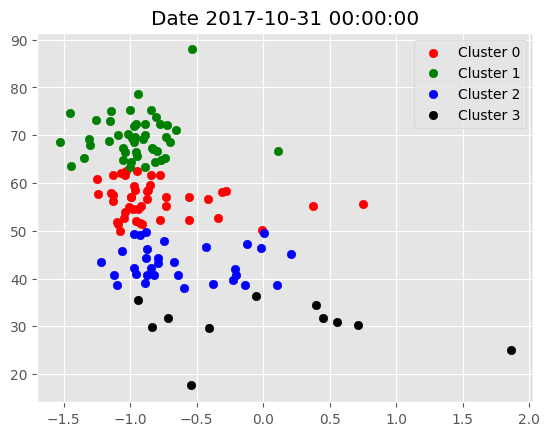

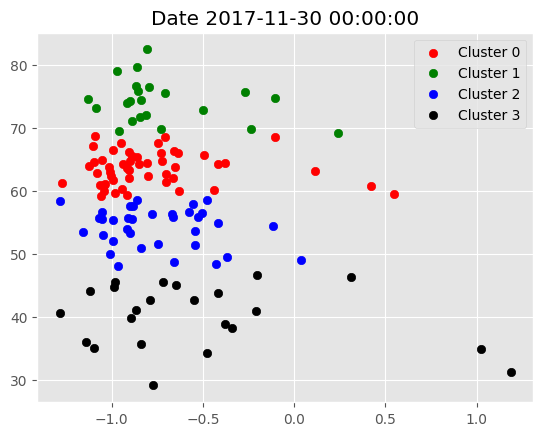

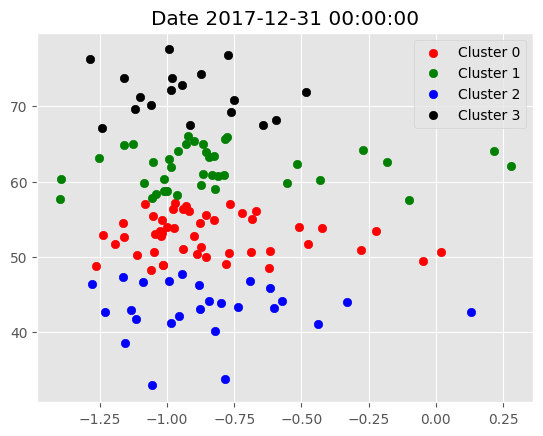

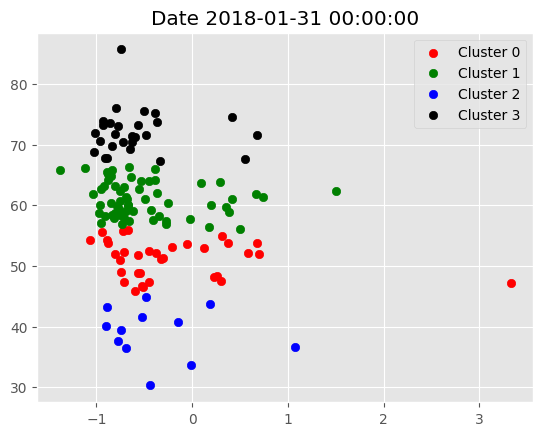

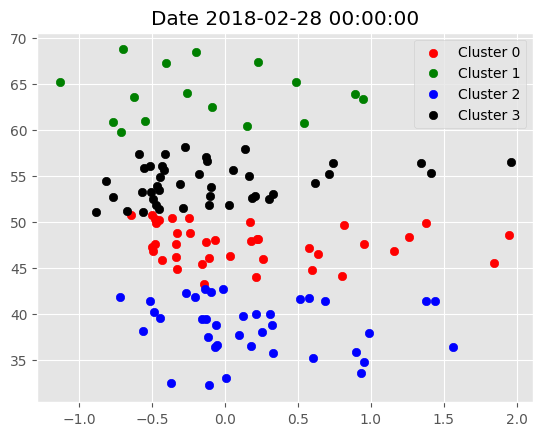

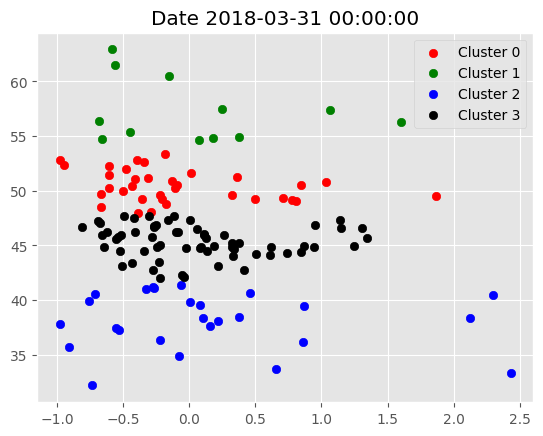

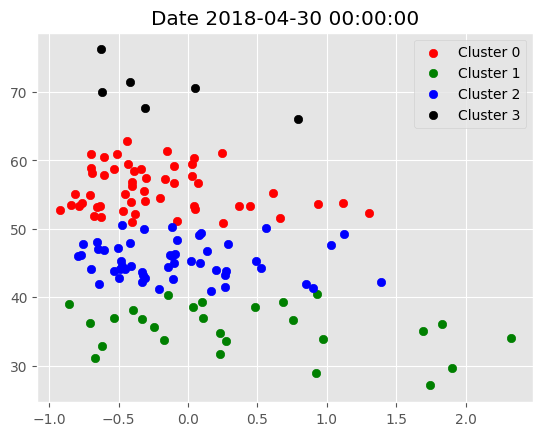

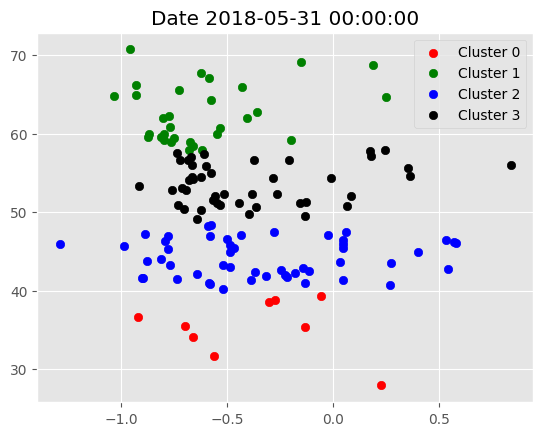

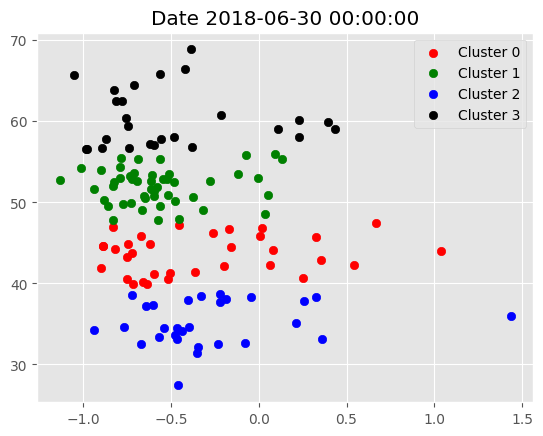

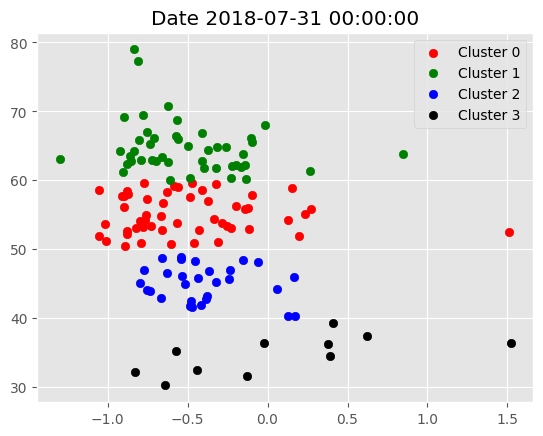

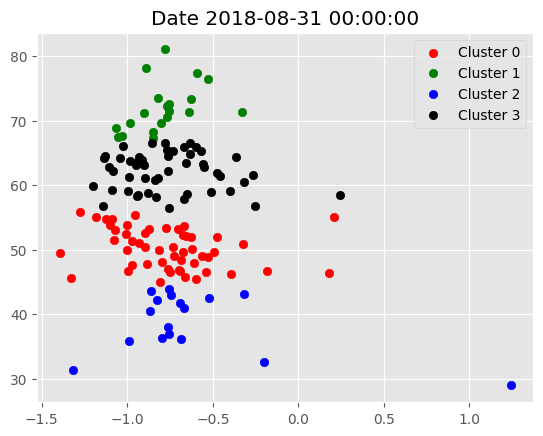

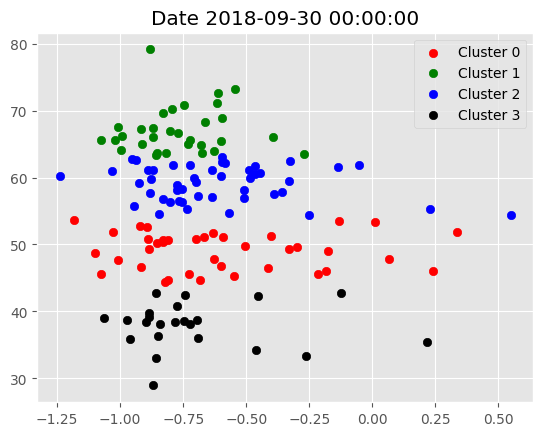

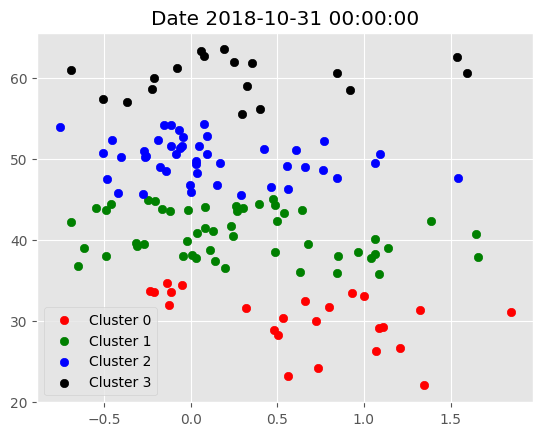

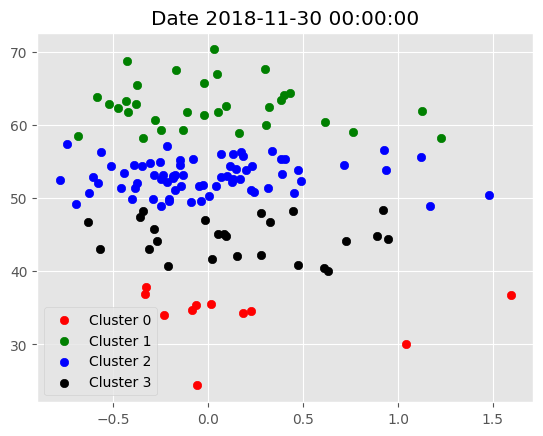

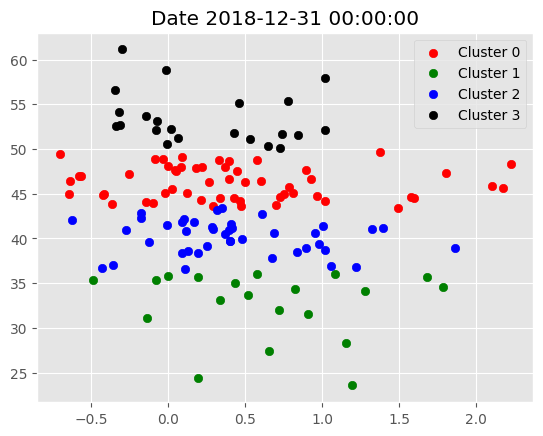

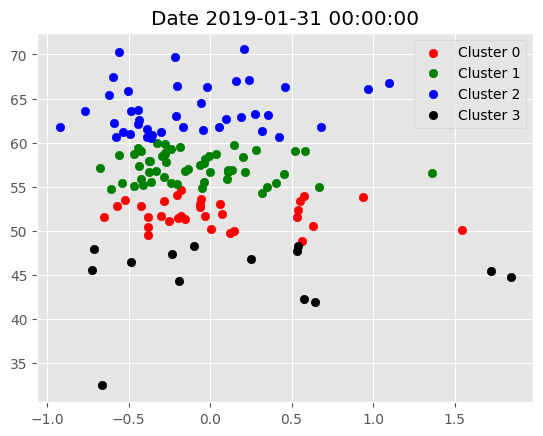

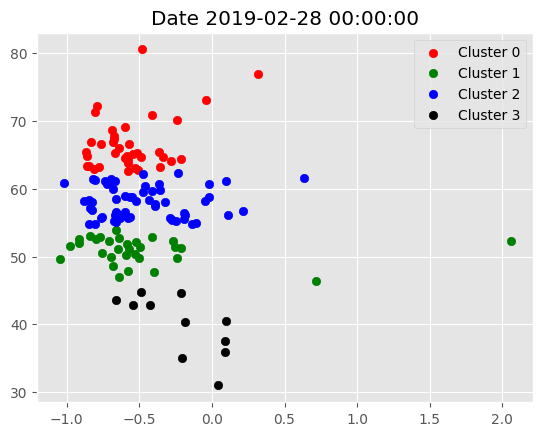

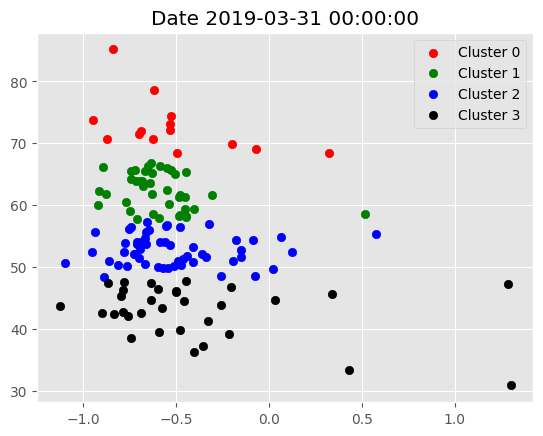

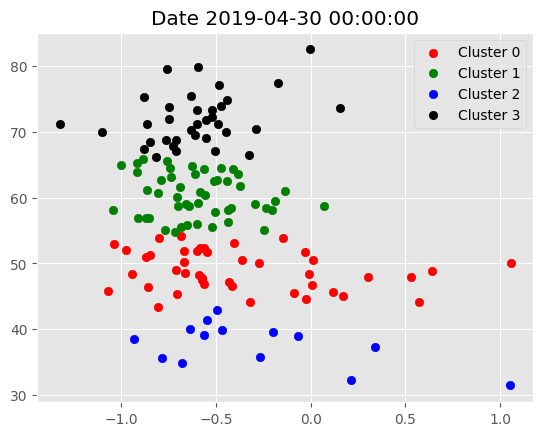

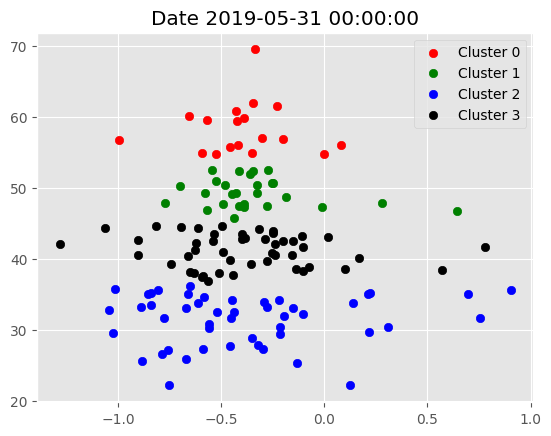

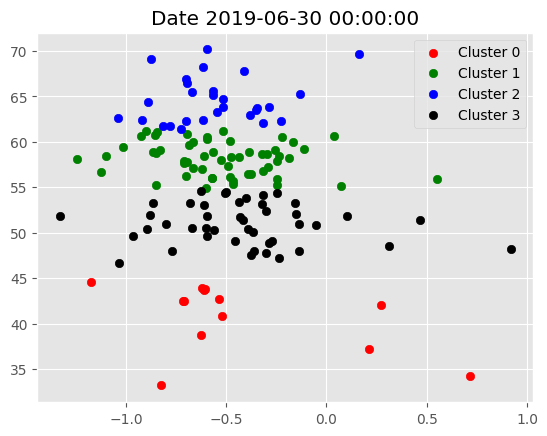

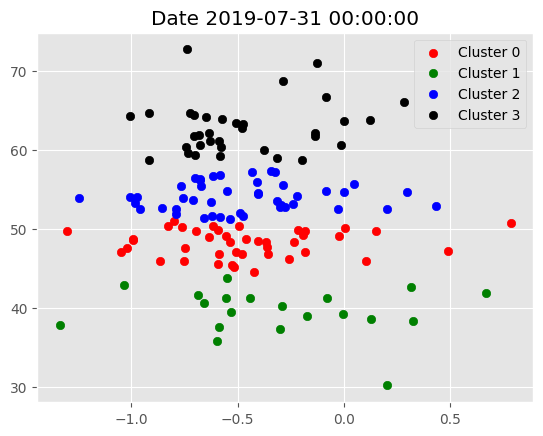

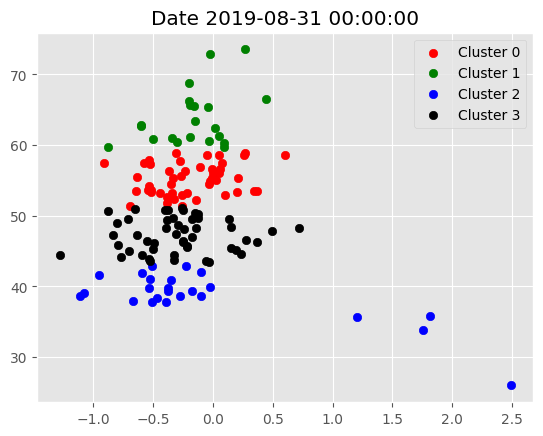

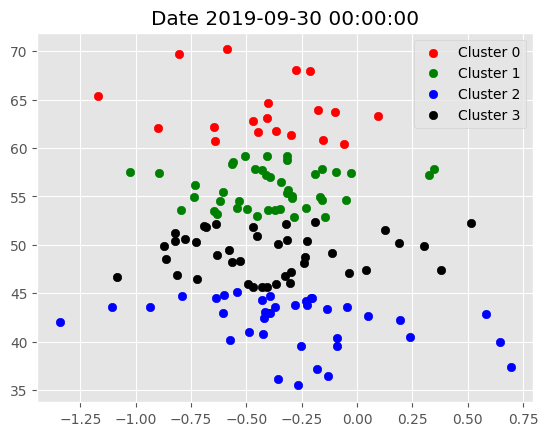

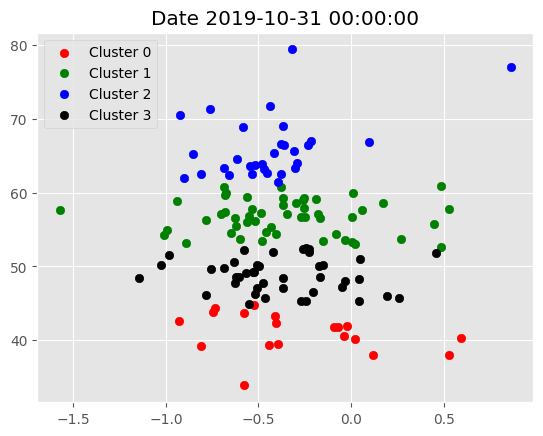

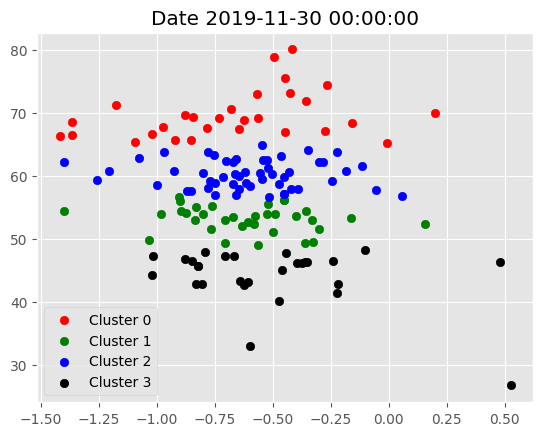

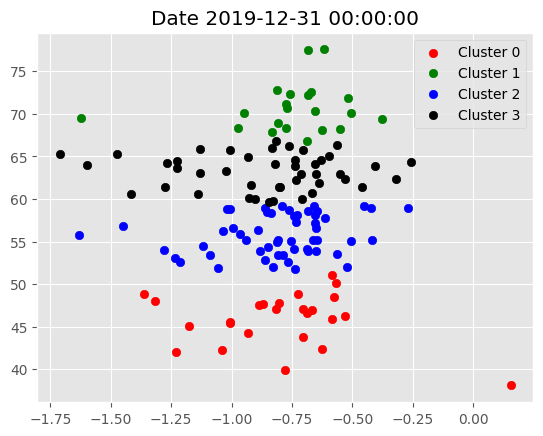

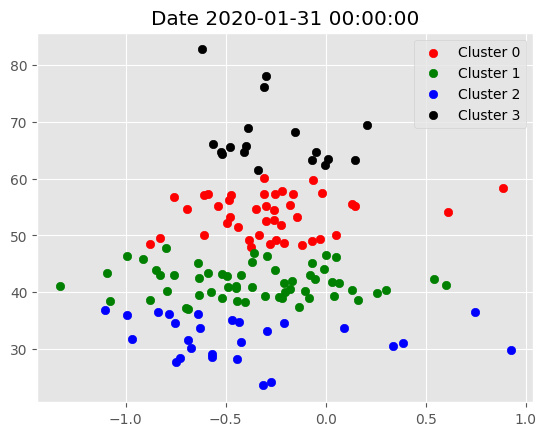

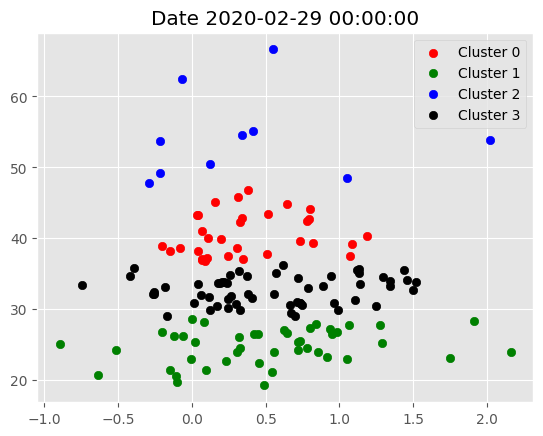

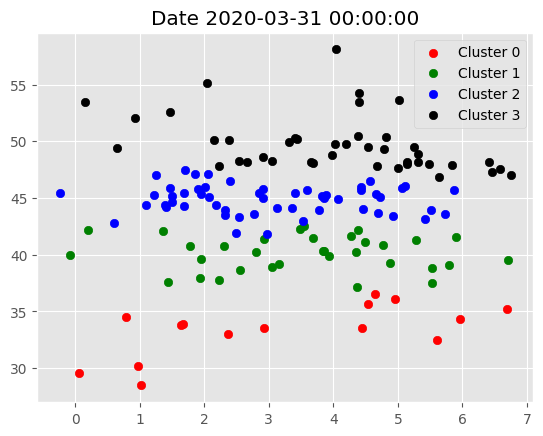

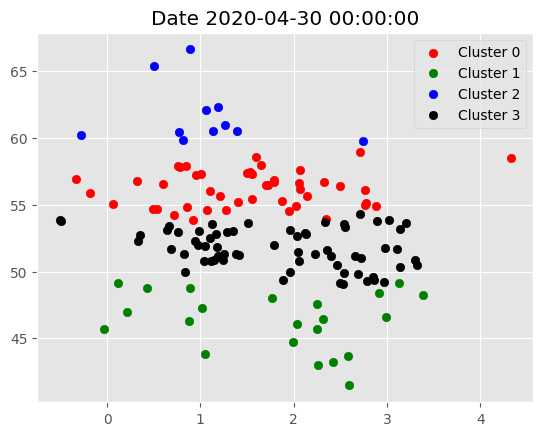

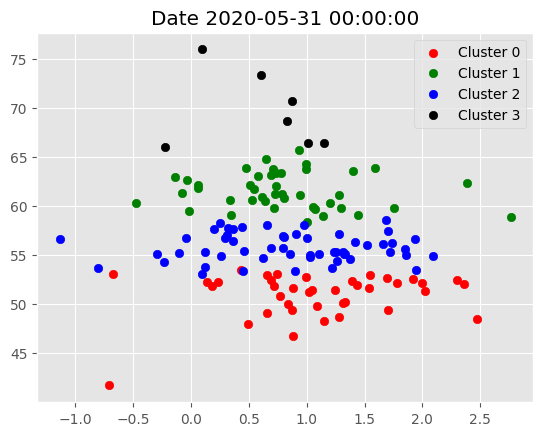

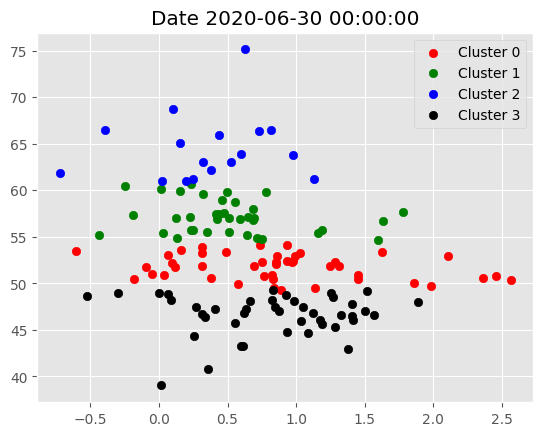

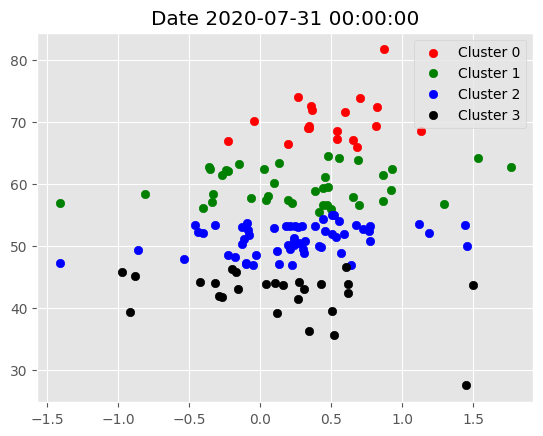

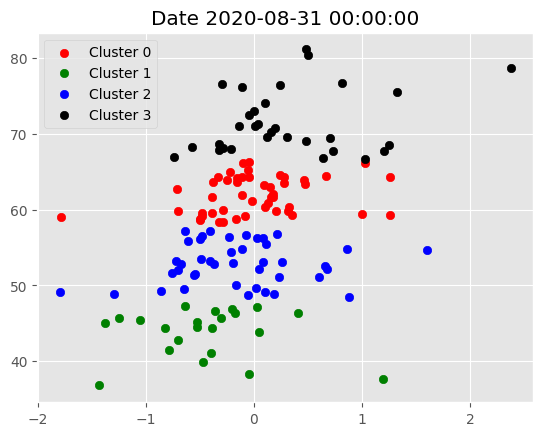

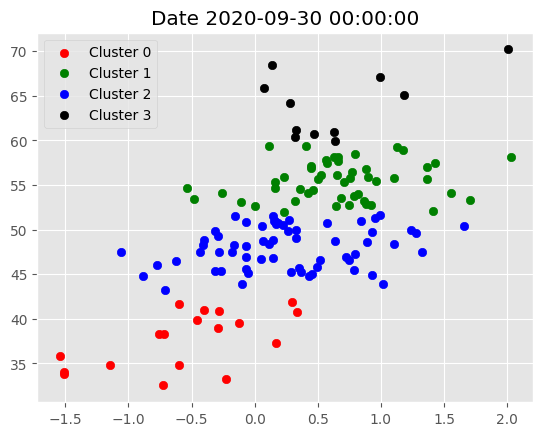

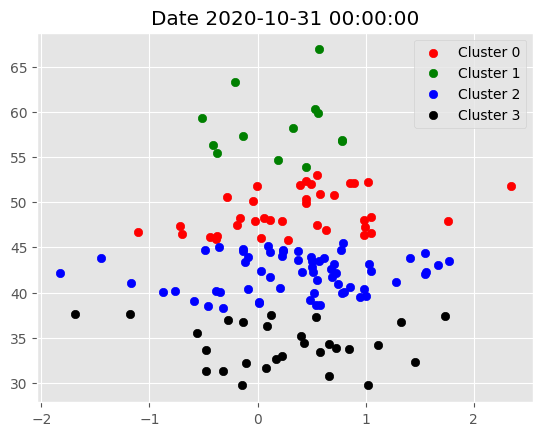

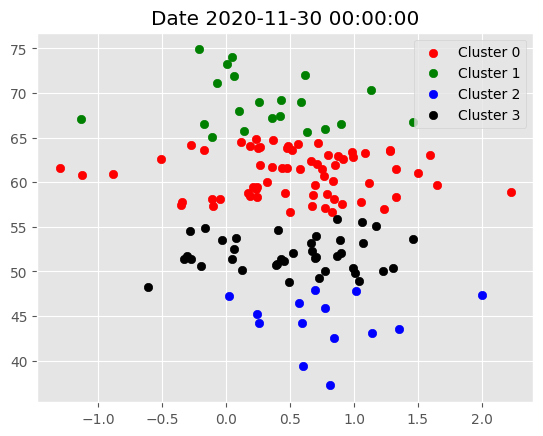

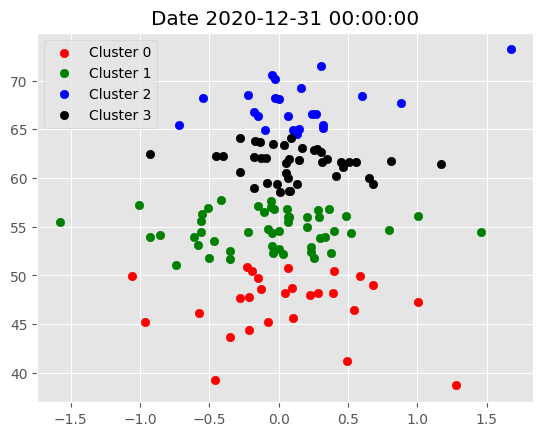

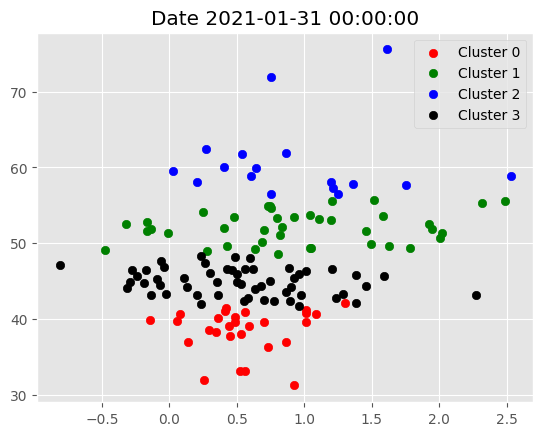

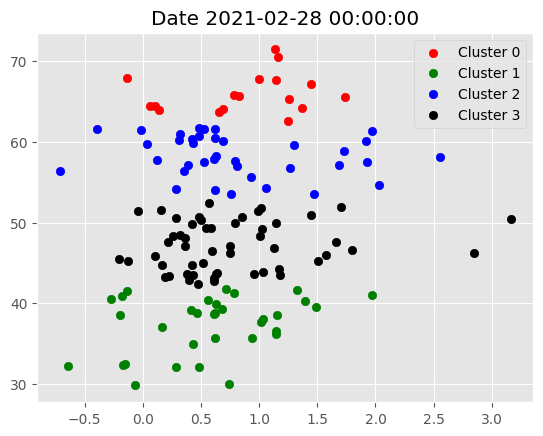

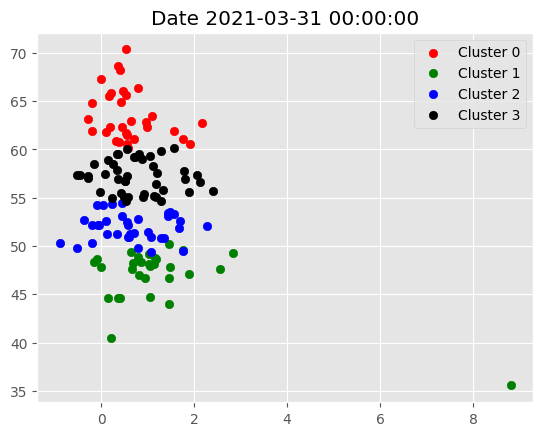

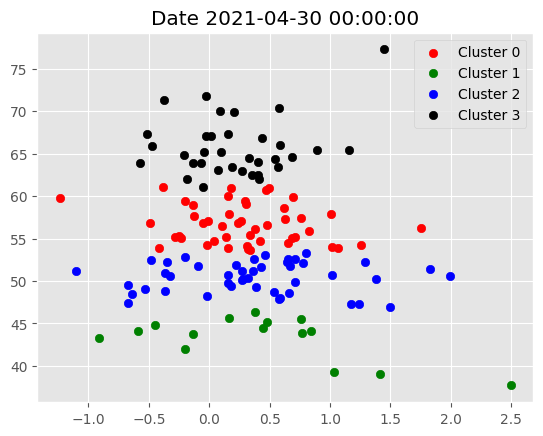

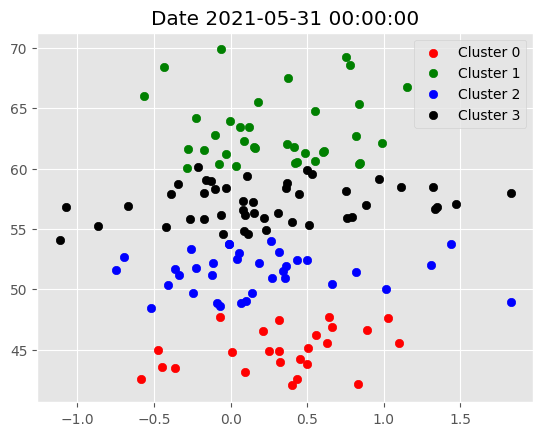

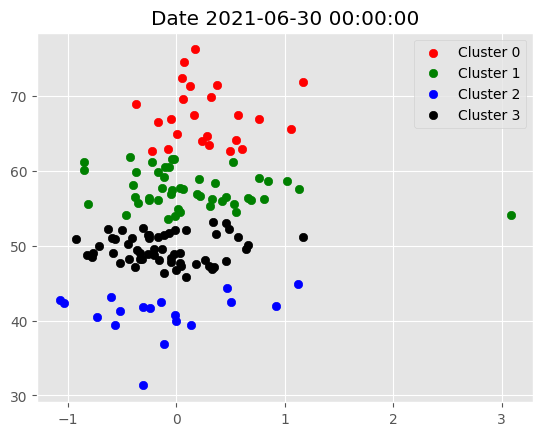

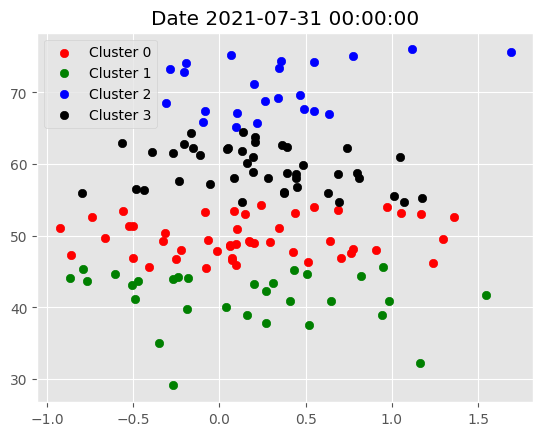

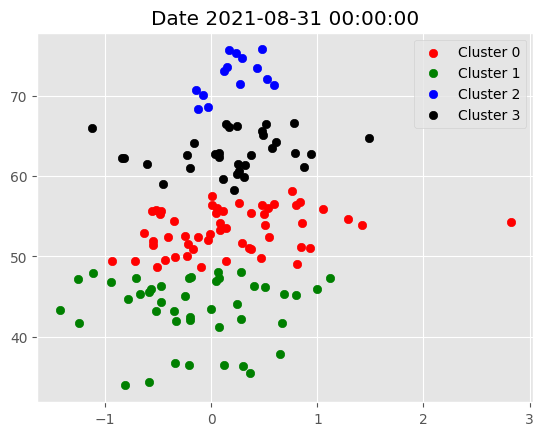

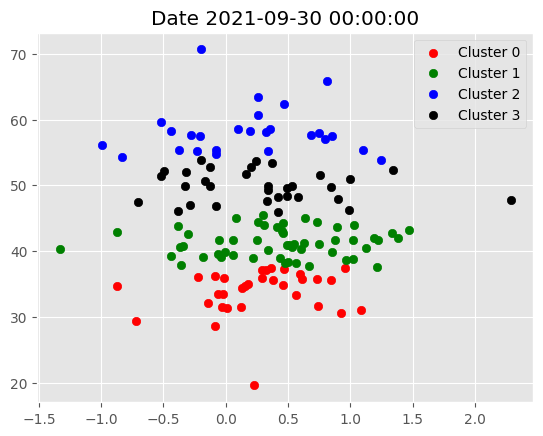

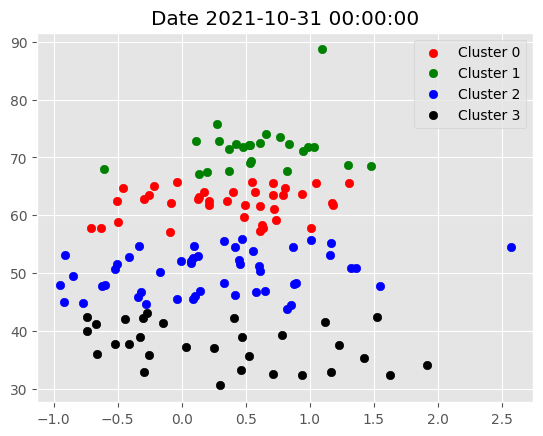

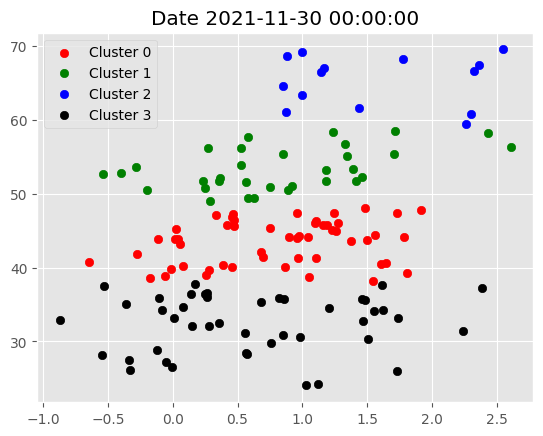

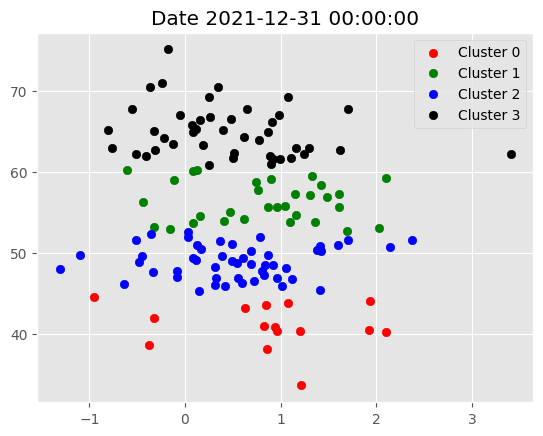

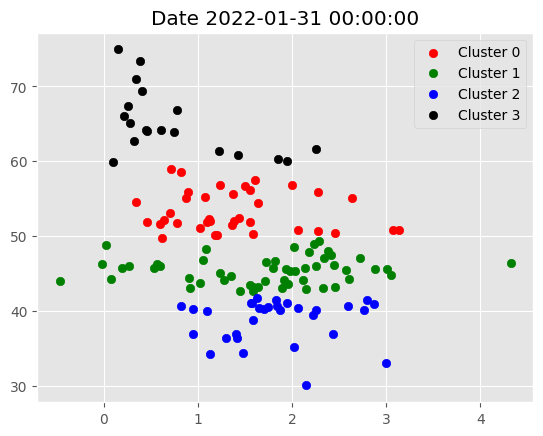

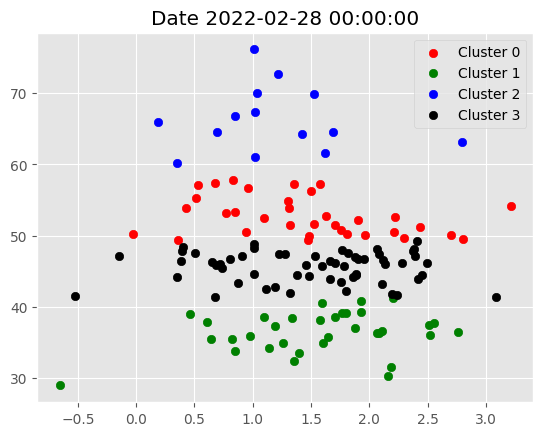

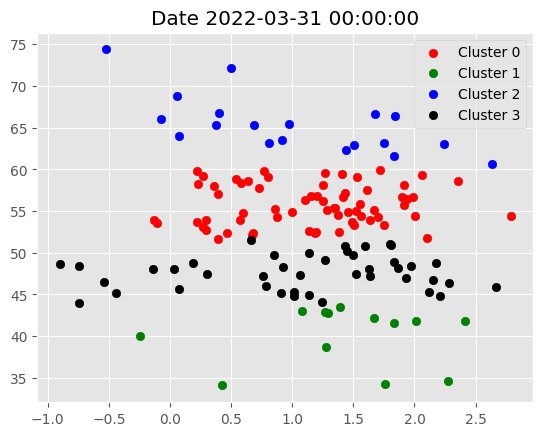

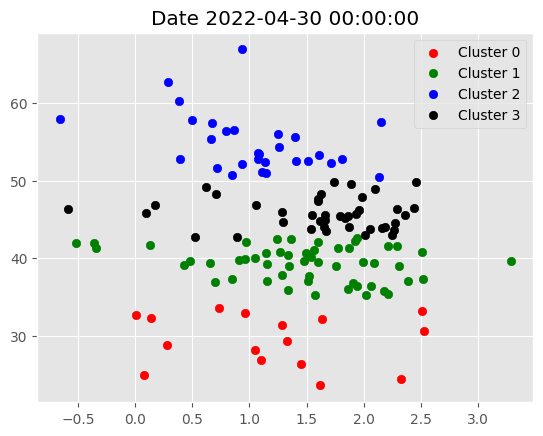

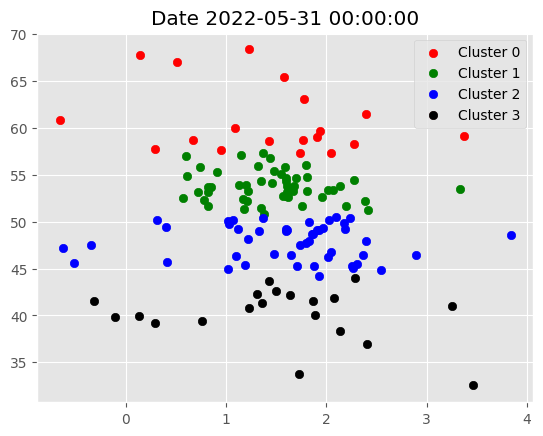

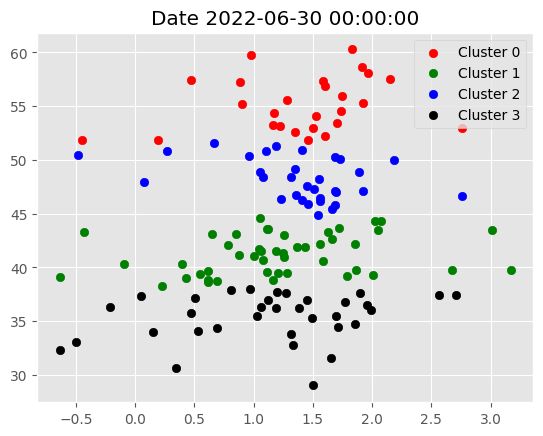

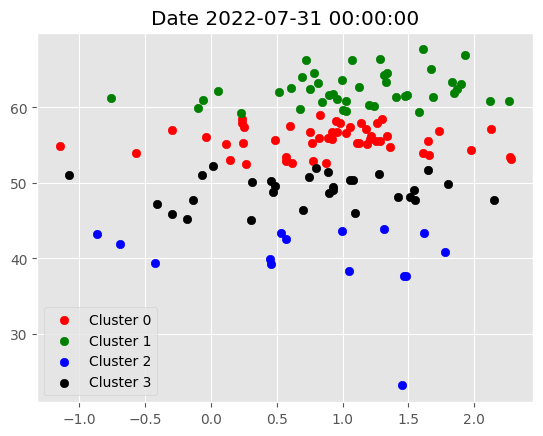

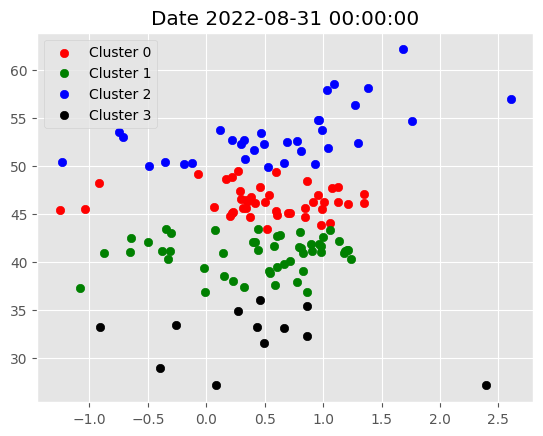

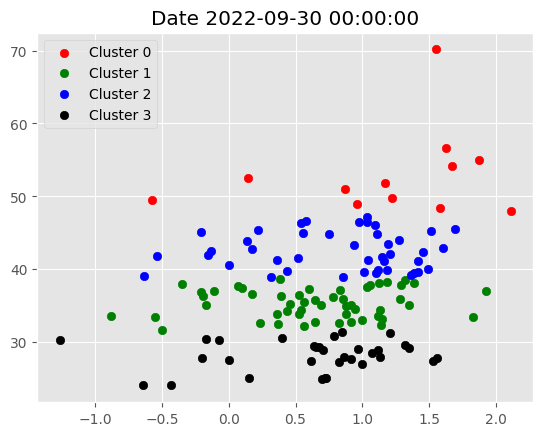

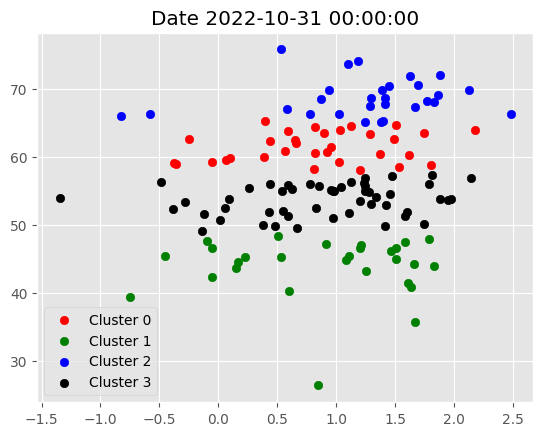

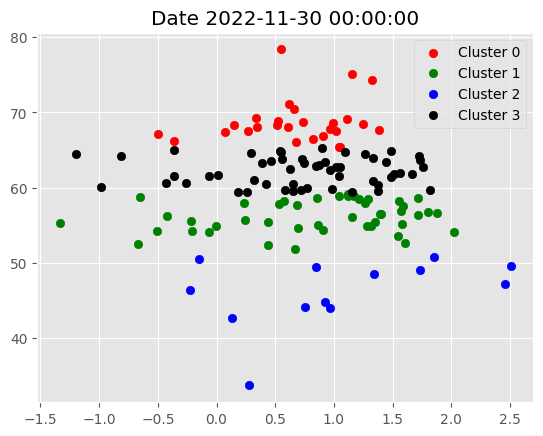

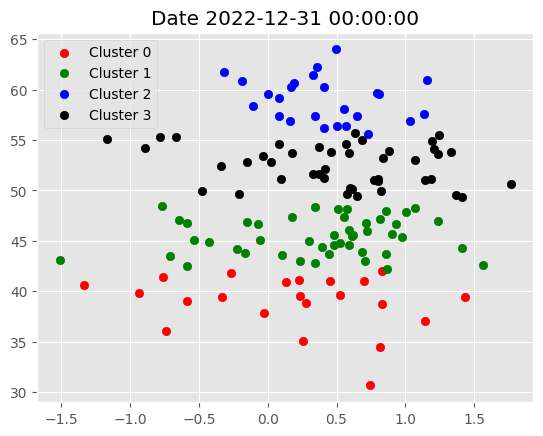

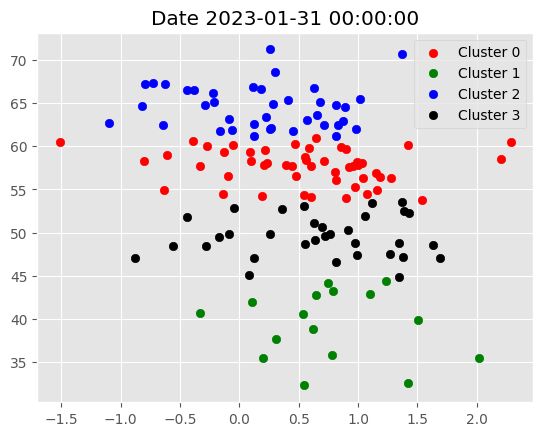

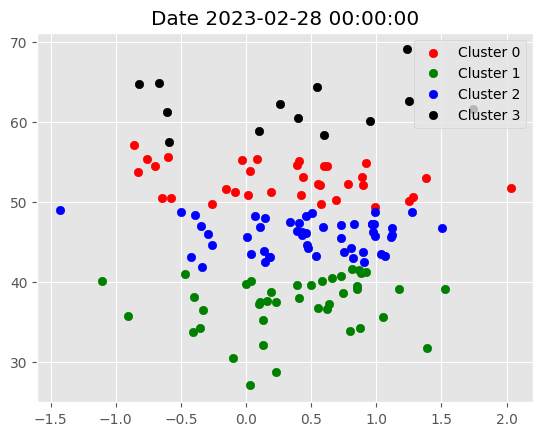

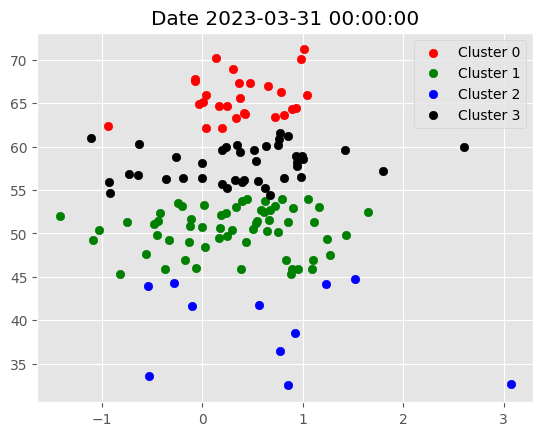

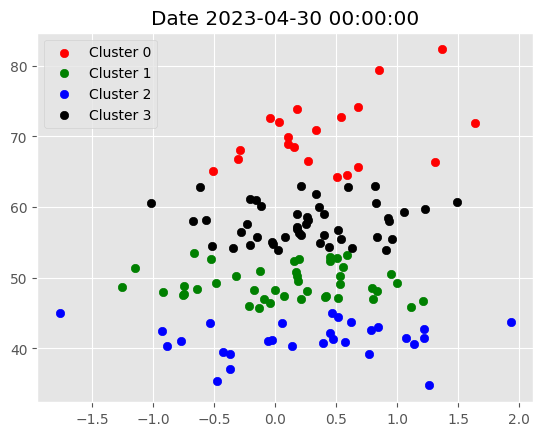

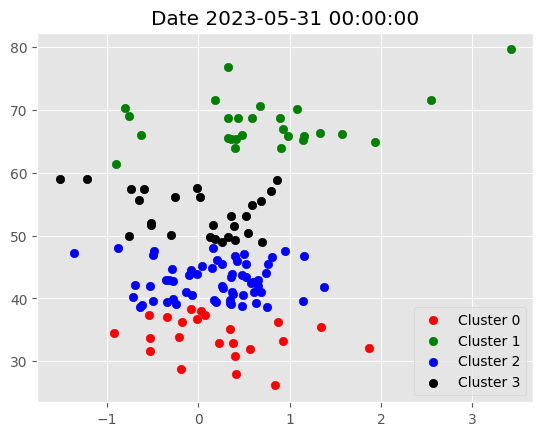

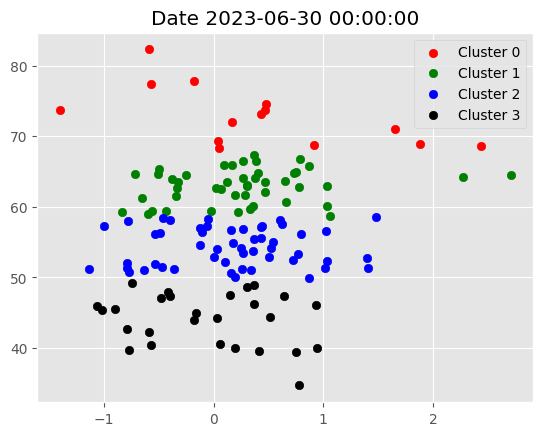

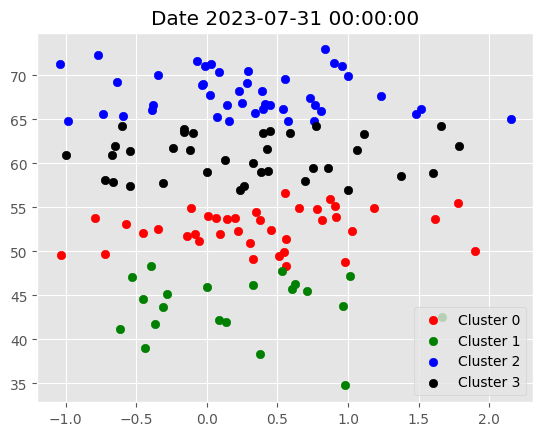

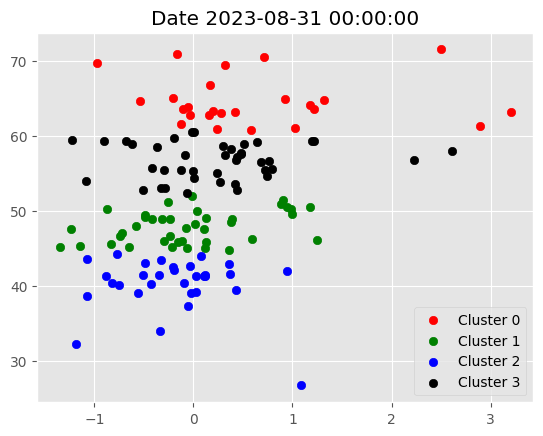

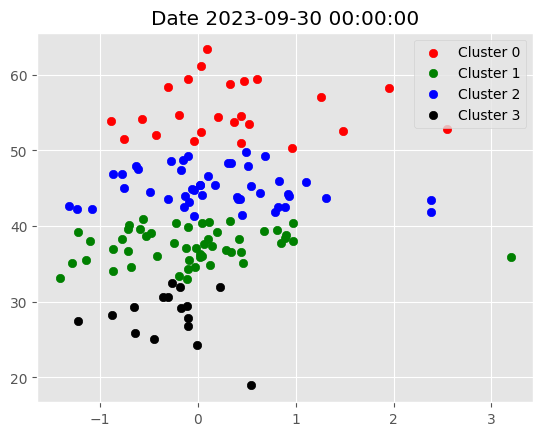

In [42]:
plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [43]:
target_rsi_values = [30,45,55,70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 1] = target_rsi_values

initial_centroids

array([[ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])


### 7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization

- First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.

- Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.

In [44]:
from sklearn.cluster import KMeans

data = data.drop('cluster', axis=1)

def get_clusters(df):
    df['cluster'] = KMeans(n_clusters=4,
                           random_state=0,
                           init=initial_centroids).fit(df).labels_
    return df

data = data.dropna().groupby('date', group_keys=False).apply(get_clusters)
data

garman_klass_vol        rsi    bb_low    bb_mid  bb_upper  \
date       ticker                                                              
2017-10-31 AAPL           -0.001362  69.196624  3.586930  3.635012  3.683093   
           ABBV           -0.046862  55.247845  4.144826  4.192355  4.239884   
           ABT            -0.008097  53.844851  3.863786  3.887954  3.912122   
           ACN            -0.005890  69.365205  4.779217  4.819920  4.860623   
           ADBE            0.000067  70.089317  4.948186  5.089292  5.230398   
...                             ...        ...       ...       ...       ...   
2023-09-30 WDAY            0.000141  43.976804  5.435794  5.495242  5.554691   
           WFC            -0.001425  40.920255  3.662032  3.703409  3.744787   
           WMT            -0.000231  54.722598  3.972207  3.990127  4.008046   
           XOM            -0.001870  59.440154  4.634297  4.675415  4.716533   
           XYZ             0.000338  25.939817  3.794872  3.980555  4.166238   

                        atr      macd  return_1m  return_2m  return_3m  \
date       ticker                                                        
2017-10-31 AAPL   -0.906737 -0.039274   0.096808   0.015250   0.044955   
           ABBV    0.377104  0.473815   0.022728   0.098590   0.091379   
           ABT    -1.040782  0.276132   0.021276   0.034308   0.034801   
           ACN    -0.986544  0.352342   0.064180   0.048454   0.037203   
           ADBE   -0.887926  0.612102   0.174152   0.062497   0.061392   
...                     ...       ...        ...        ...        ...   
2023-09-30 WDAY   -0.127898 -0.306858  -0.062413  -0.016777   0.004919   
           WFC    -0.560271 -0.282325  -0.015500  -0.057917  -0.013554   
           WMT    -0.195960  0.399459  -0.000676   0.010014   0.012354   
           XOM     0.601616  1.400623   0.046947   0.046139   0.030496   
           XYZ    -0.638305 -0.990293  -0.222723  -0.247423  -0.123607   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAPL     0.028875   0.038941    0.035228  1.276514 -0.251053   
           ABBV     0.056495   0.047273    0.044026  0.505459  0.360796   
           ABT      0.038672   0.031320    0.029294  0.833390 -0.194862   
           ACN      0.028692   0.027398    0.018728  1.203787 -0.154563   
           ADBE     0.045993   0.049515    0.041515  1.109870 -0.318478   
...                      ...        ...         ...       ...       ...   
2023-09-30 WDAY     0.017531   0.035597    0.034709  1.079481 -0.958201   
           WFC      0.016712   0.000703    0.003255  1.139542  0.259311   
           WMT      0.017574   0.016553    0.020256  0.743733 -0.258997   
           XOM      0.012838   0.008747    0.027037  1.007317 -1.088032   
           XYZ     -0.068630  -0.036876   -0.016915  2.425978  1.934056   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAPL   -0.610537  0.680865  0.488796        3  
           ABBV   -0.030539  0.178919  0.188293        2  
           ABT    -0.528598  0.255571  0.985883        2  
           ACN    -0.339711  0.270243  0.196920        3  
           ADBE   -0.184535 -0.218372 -0.687463        3  
...                     ...       ...       ...      ...  
2023-09-30 WDAY   -0.574573 -0.860196 -0.257084        1  
           WFC     1.995741 -0.458308 -1.490221        1  
           WMT    -0.509351 -0.129481  0.632258        2  
           XOM     1.679494 -0.722967 -0.271015        3  
           XYZ    -0.380210 -1.635044  0.504781        0  

[10060 rows x 19 columns]

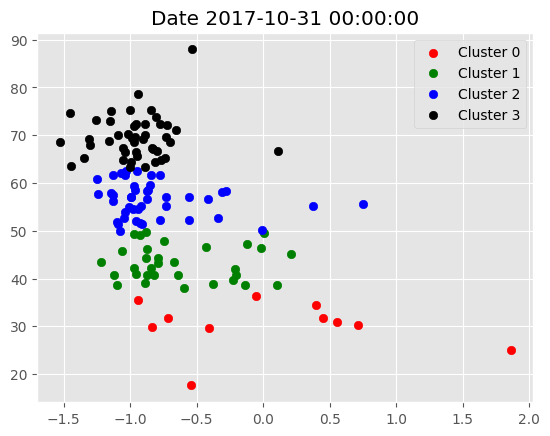

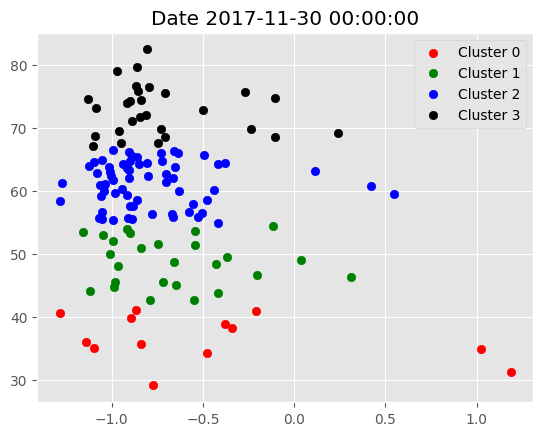

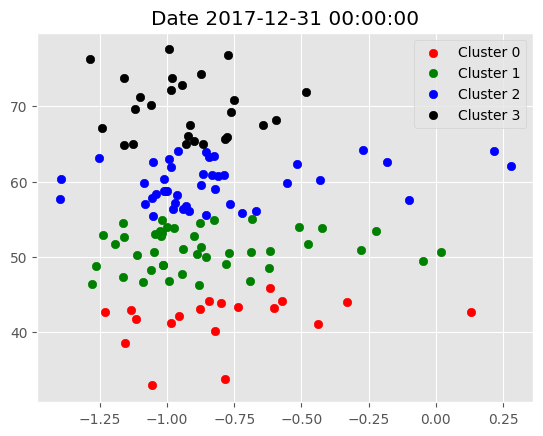

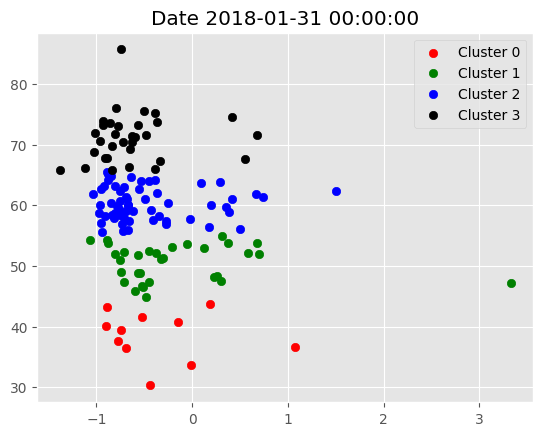

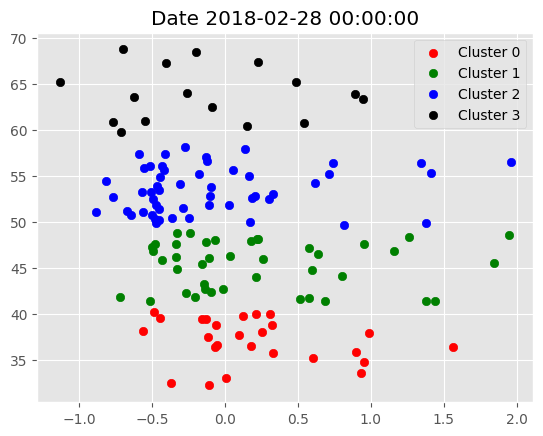

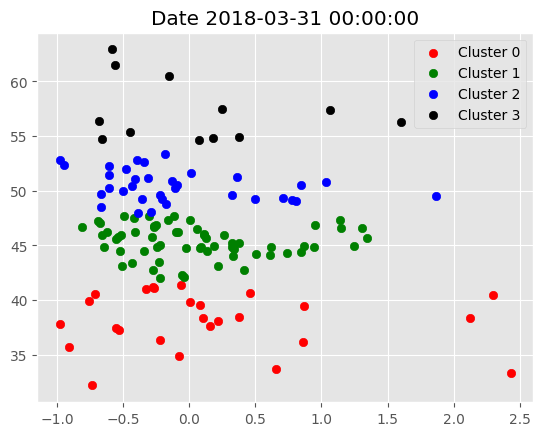

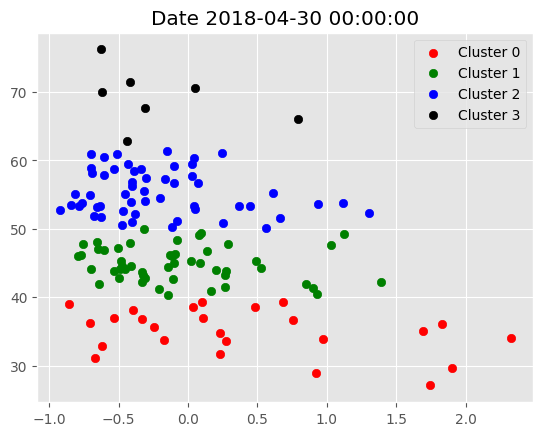

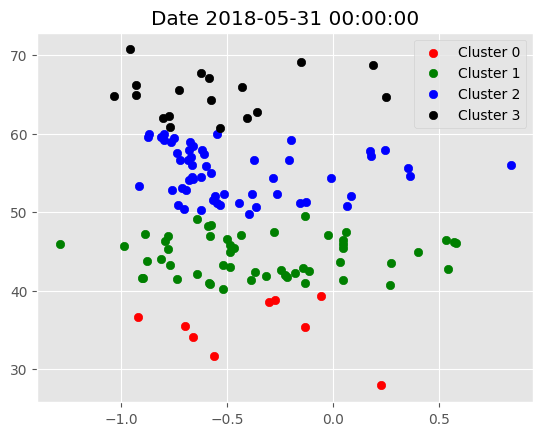

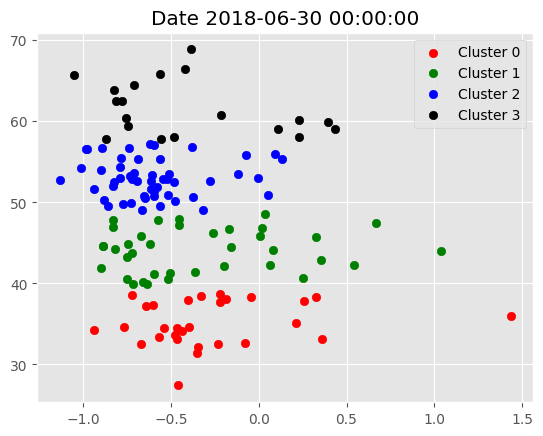

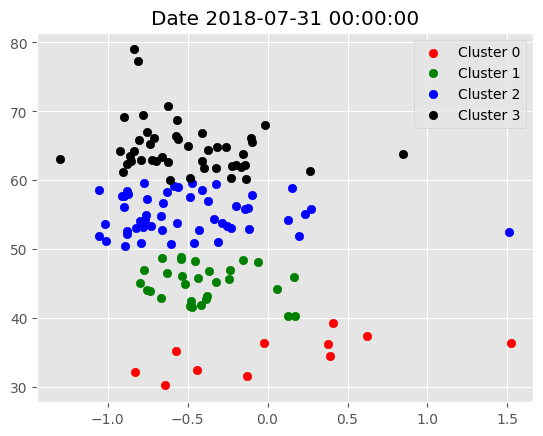

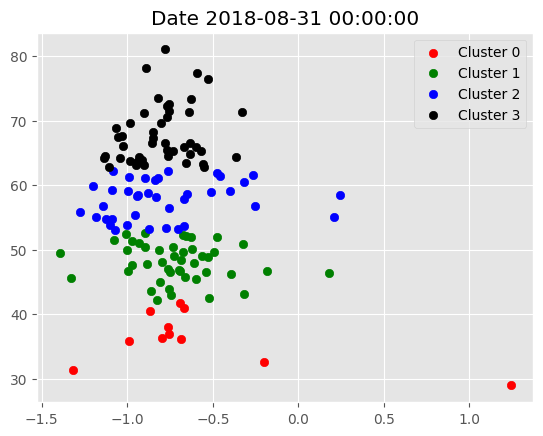

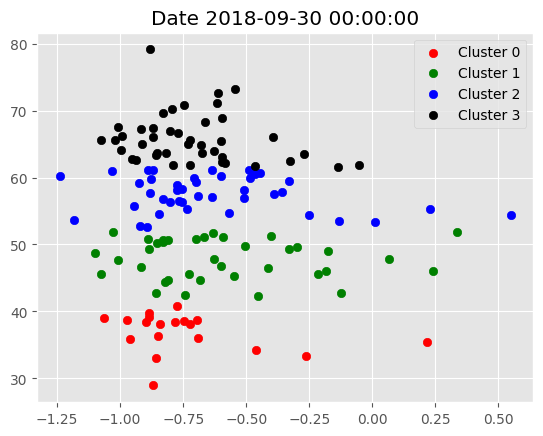

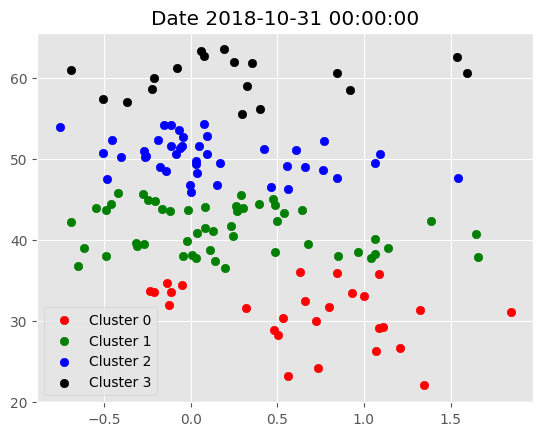

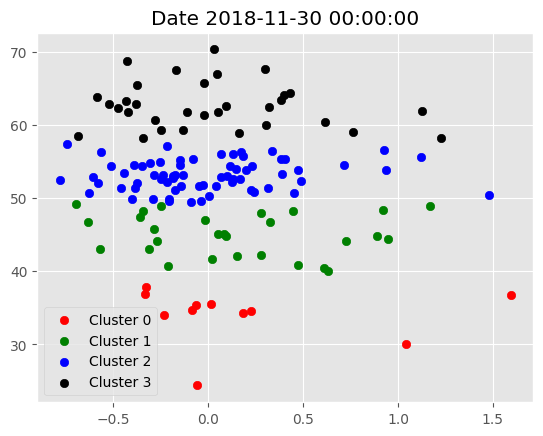

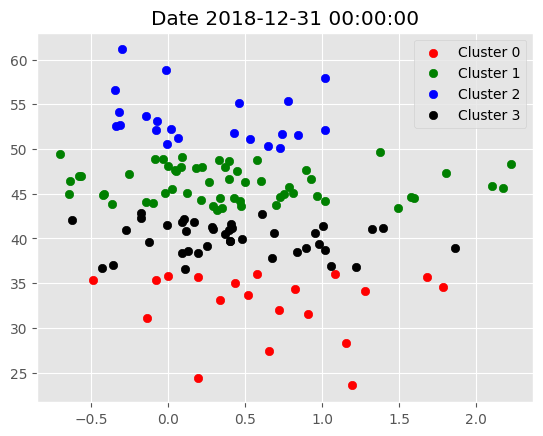

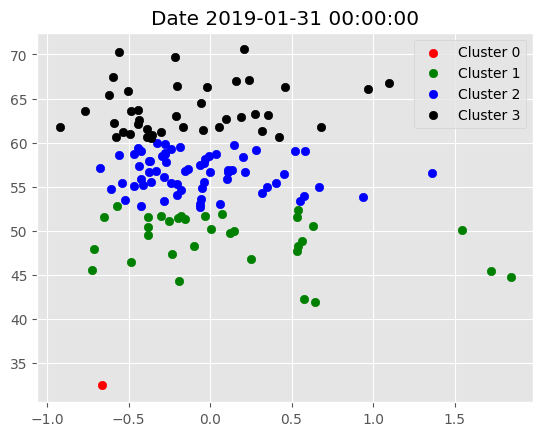

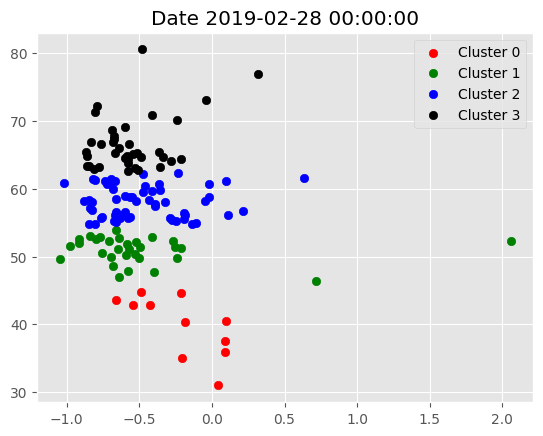

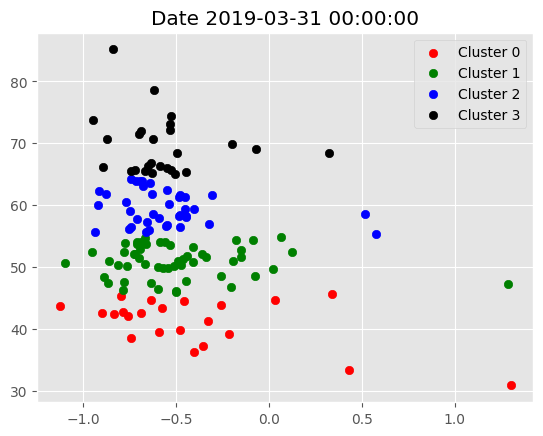

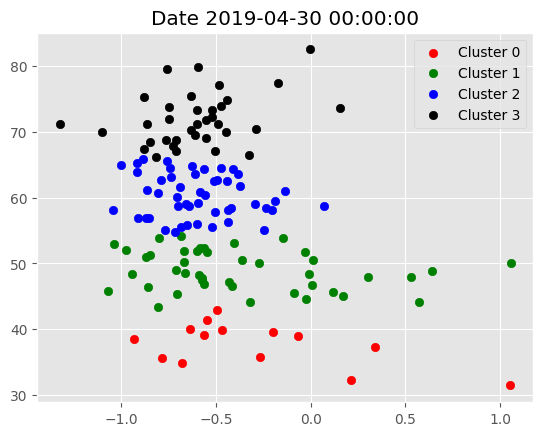

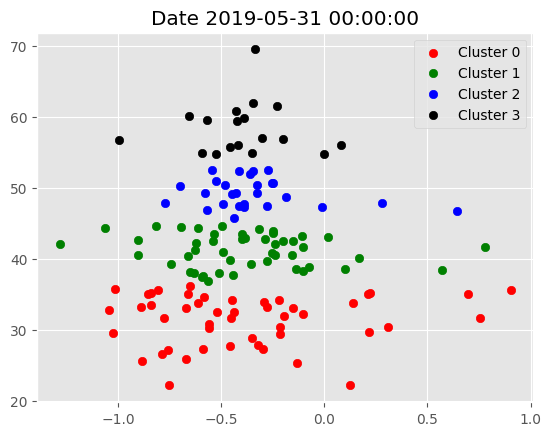

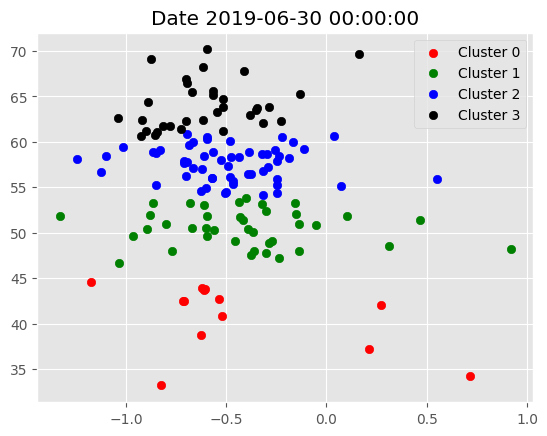

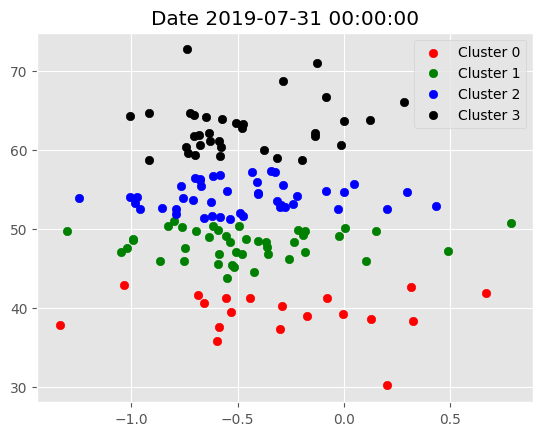

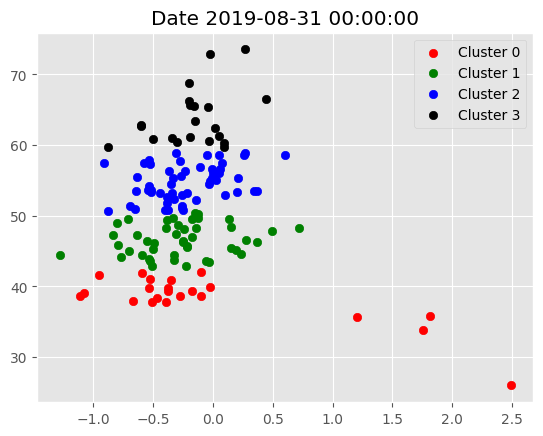

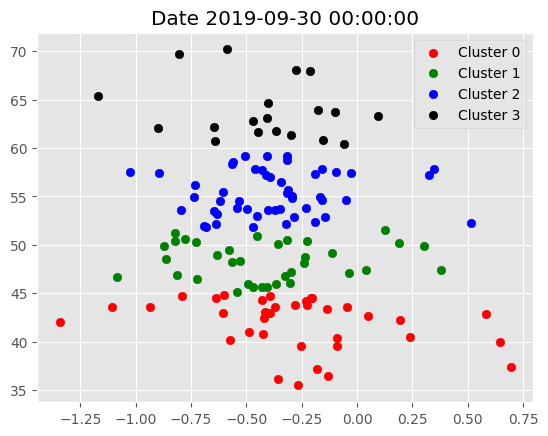

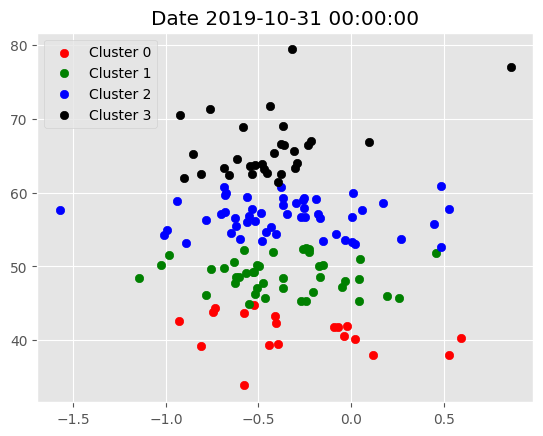

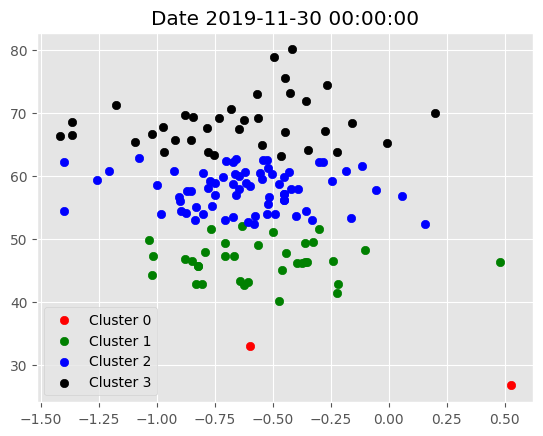

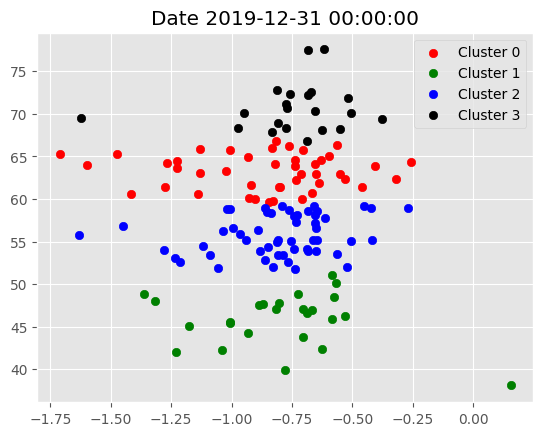

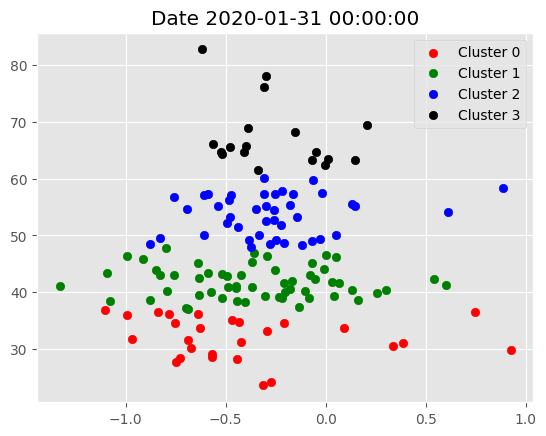

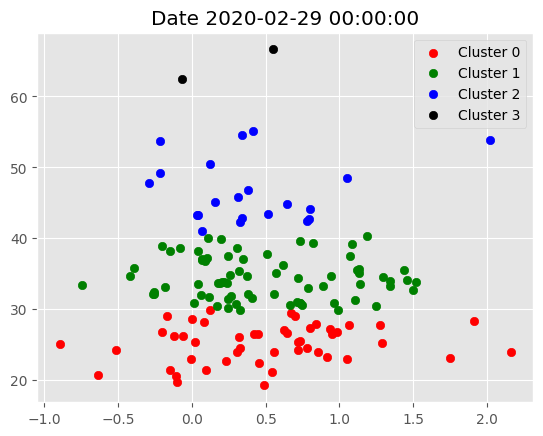

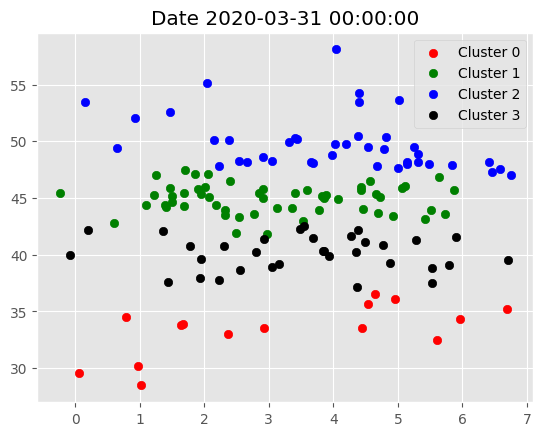

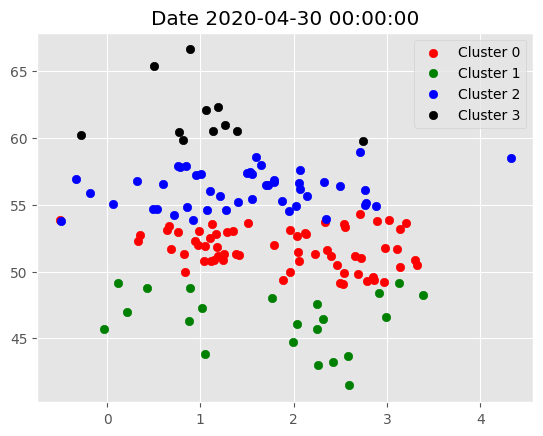

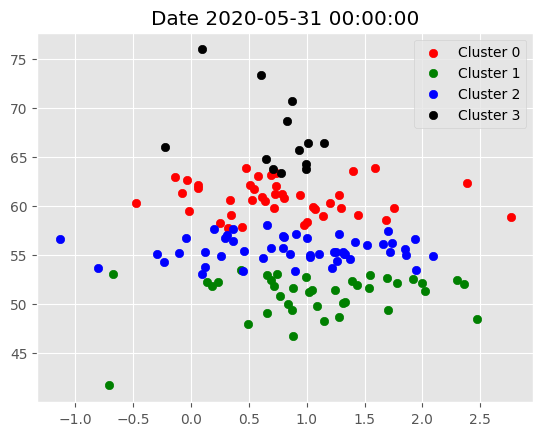

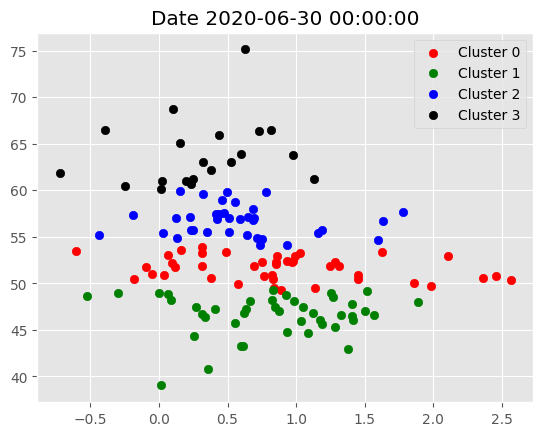

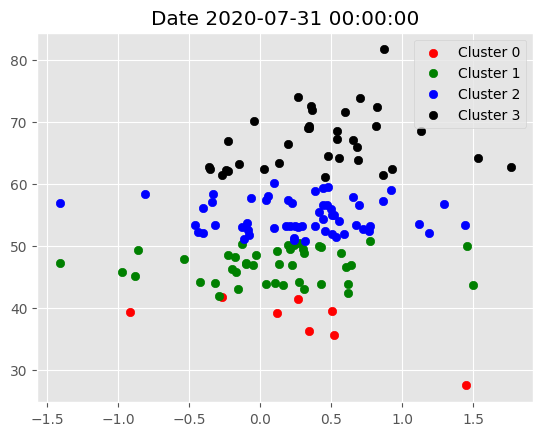

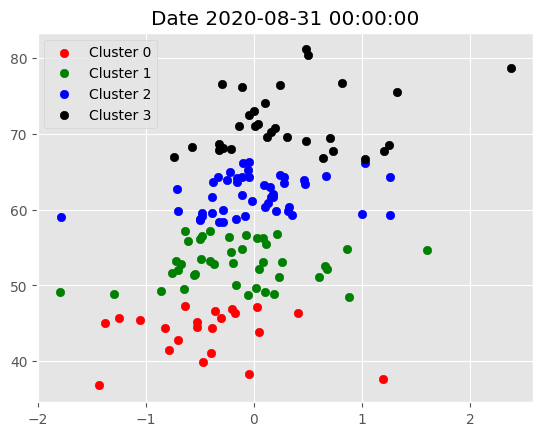

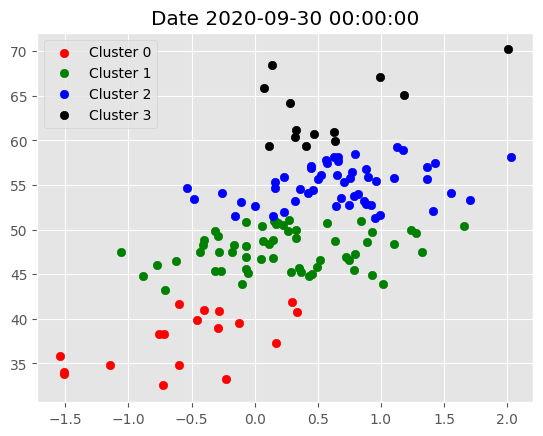

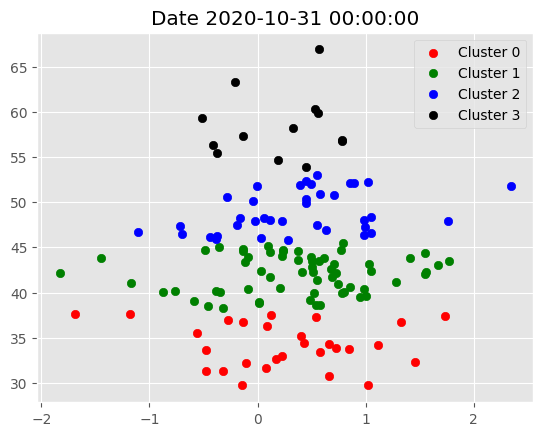

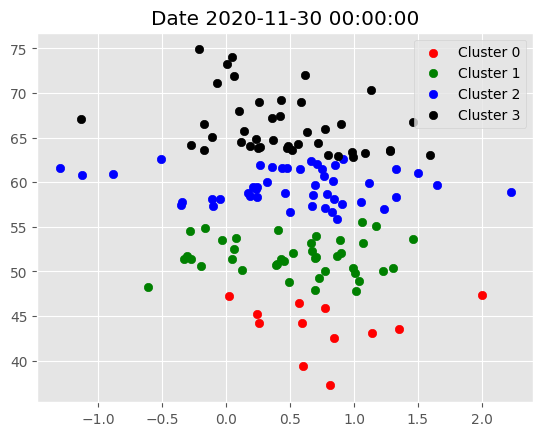

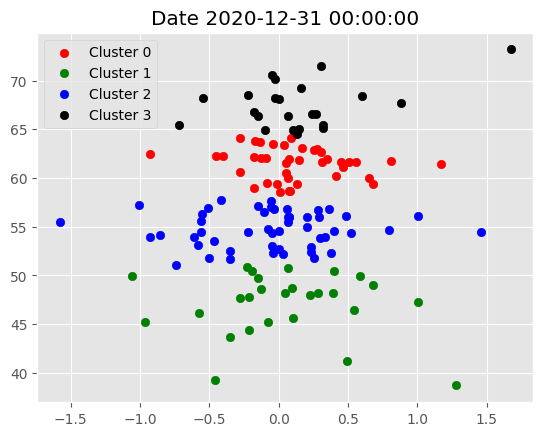

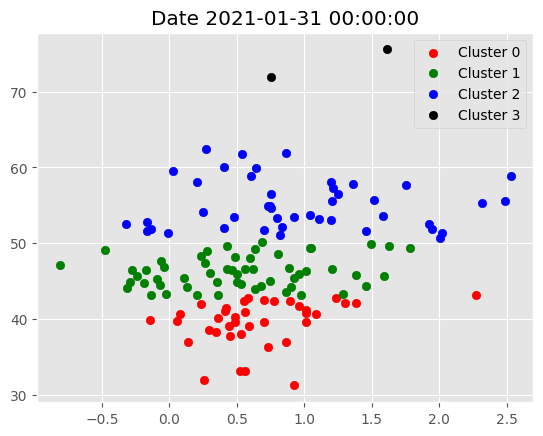

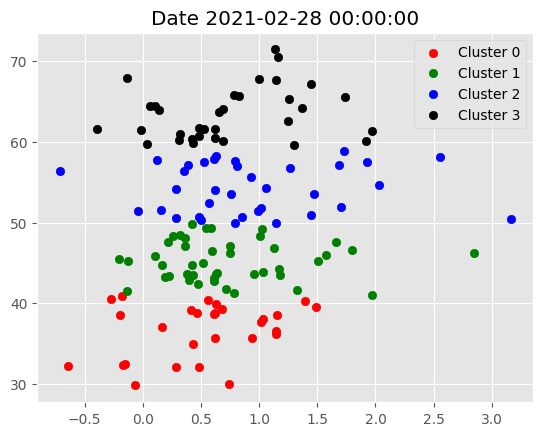

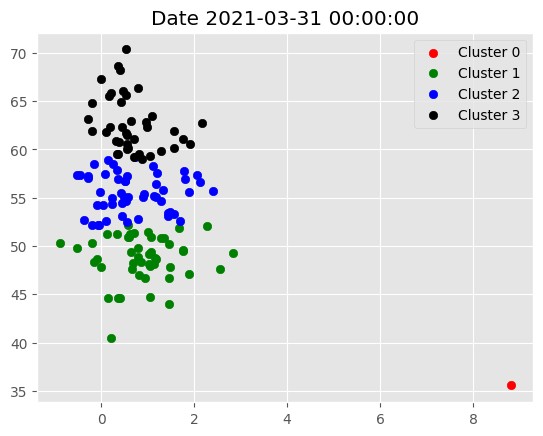

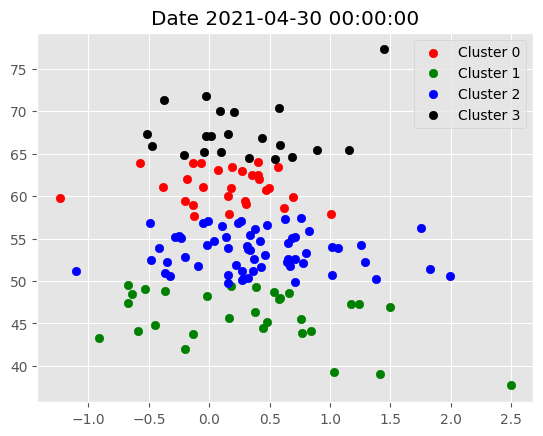

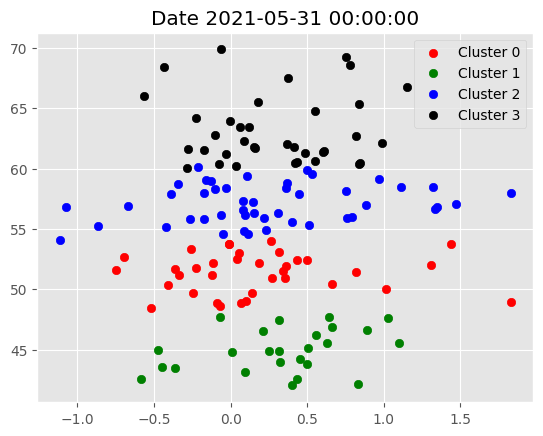

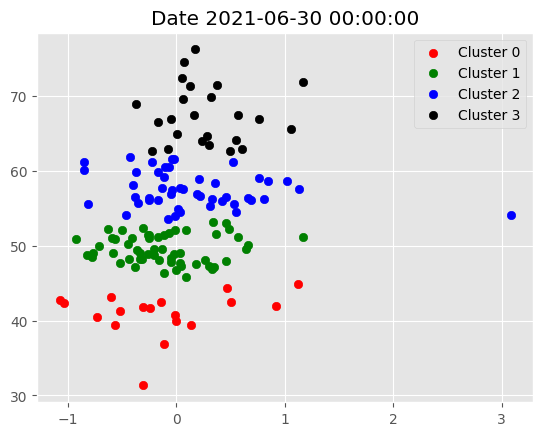

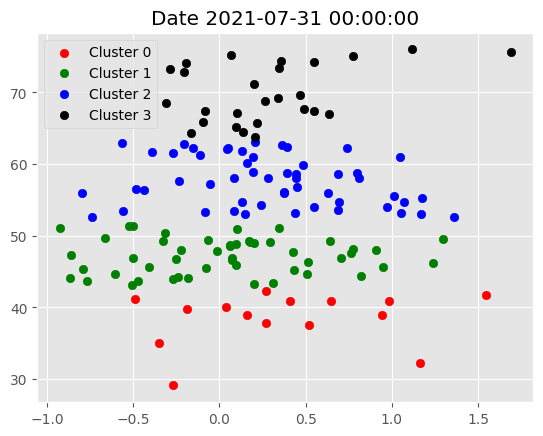

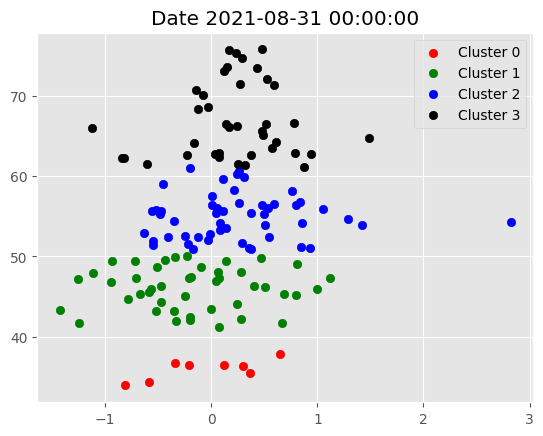

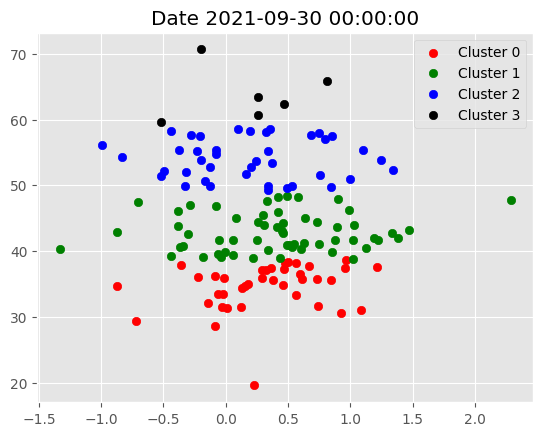

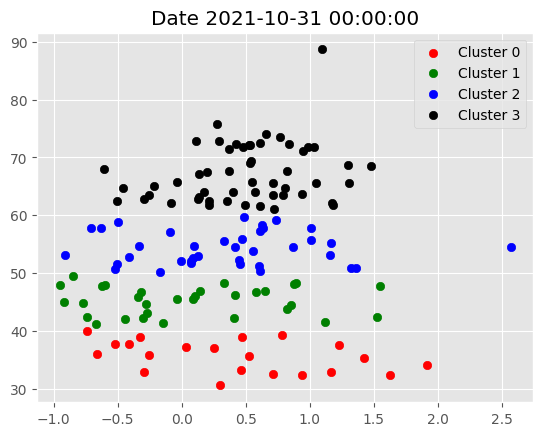

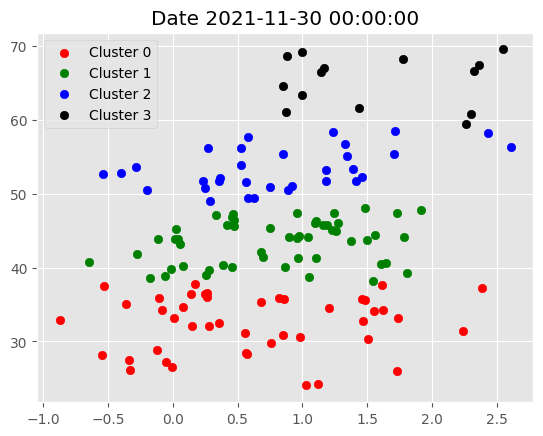

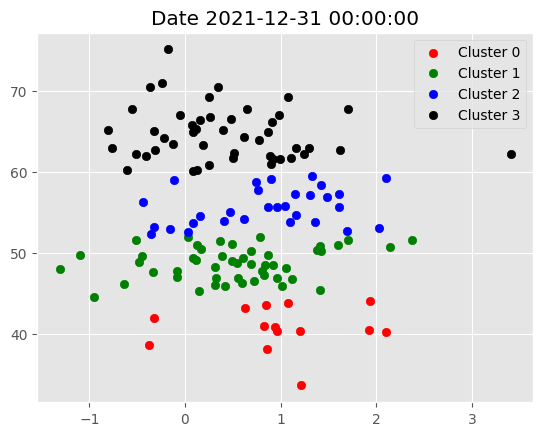

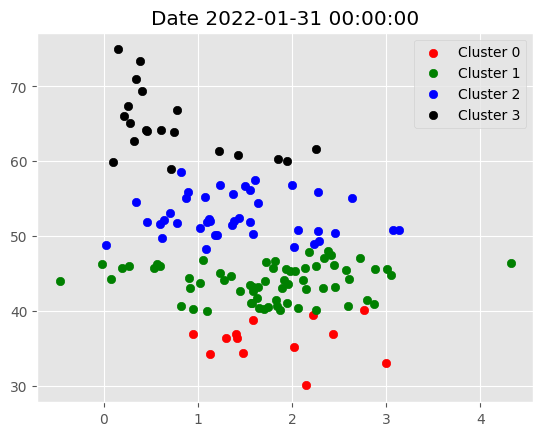

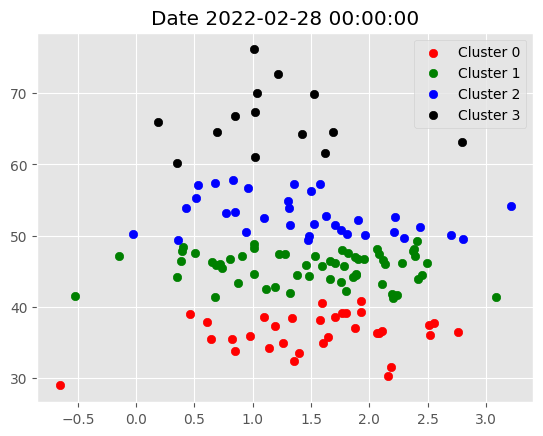

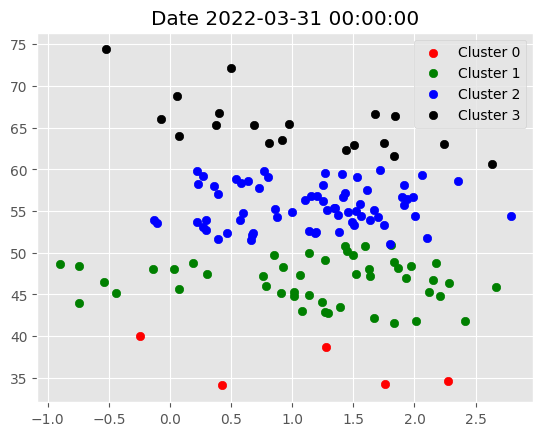

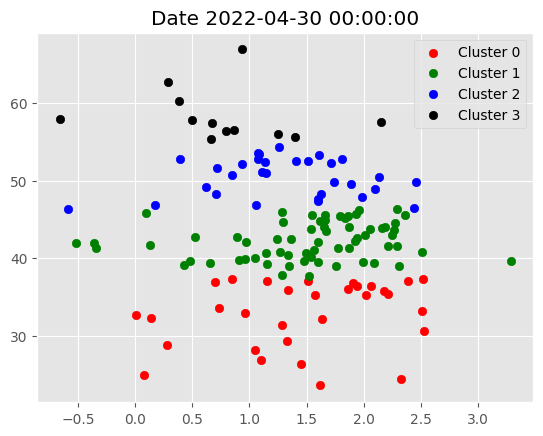

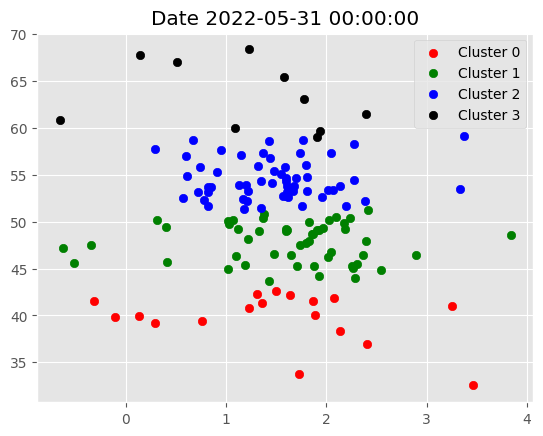

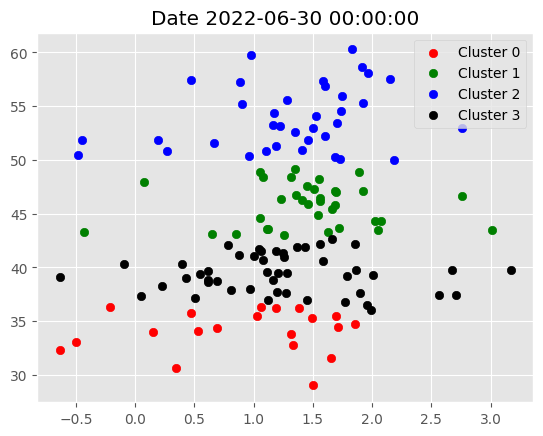

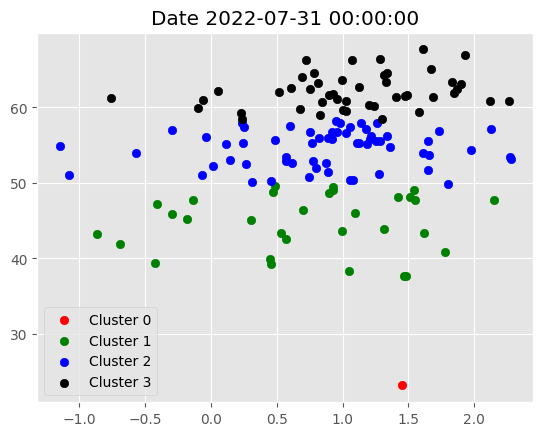

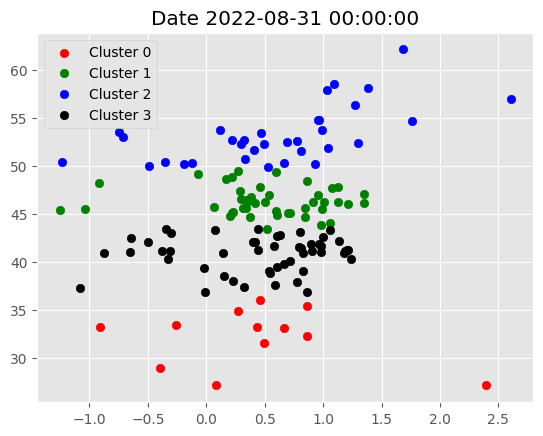

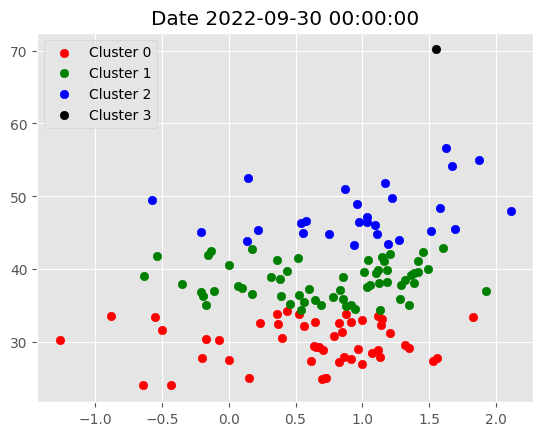

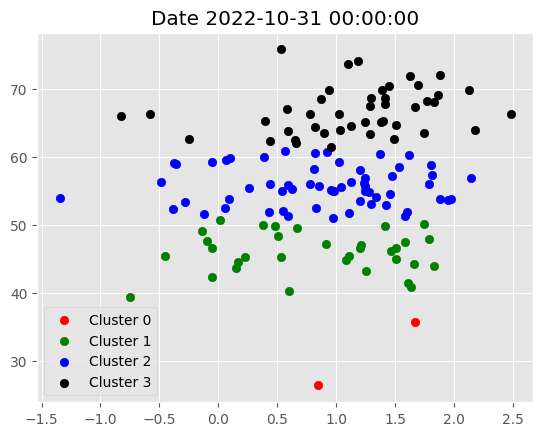

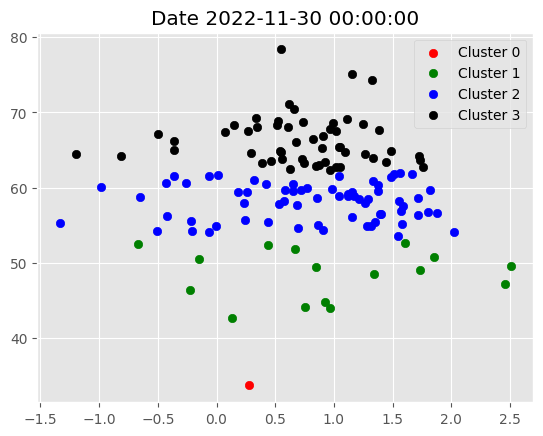

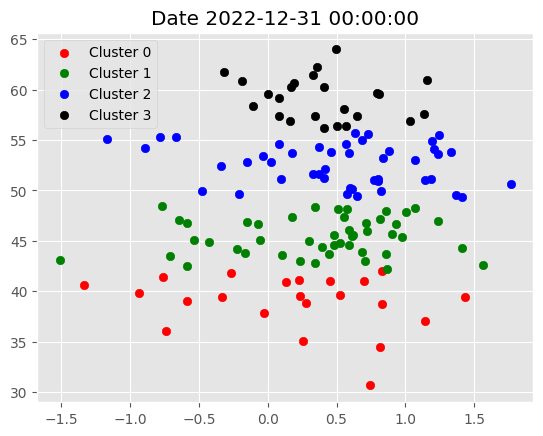

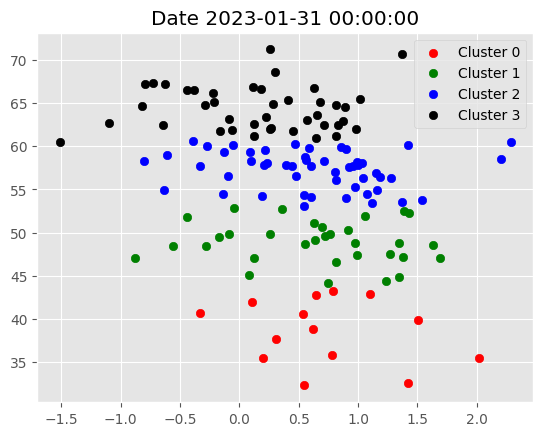

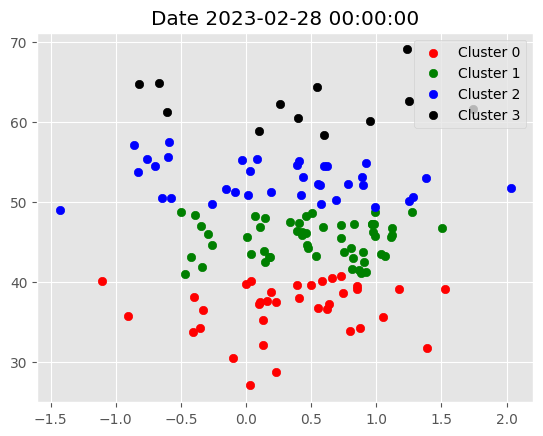

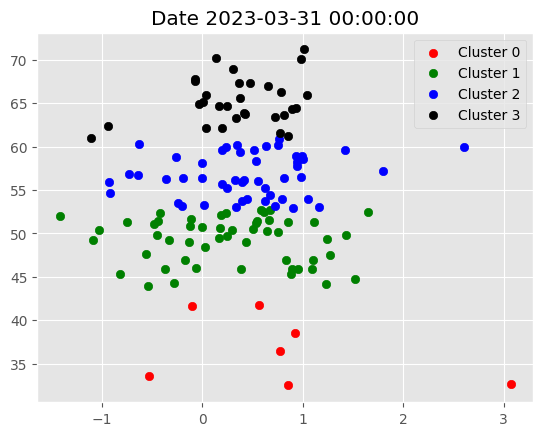

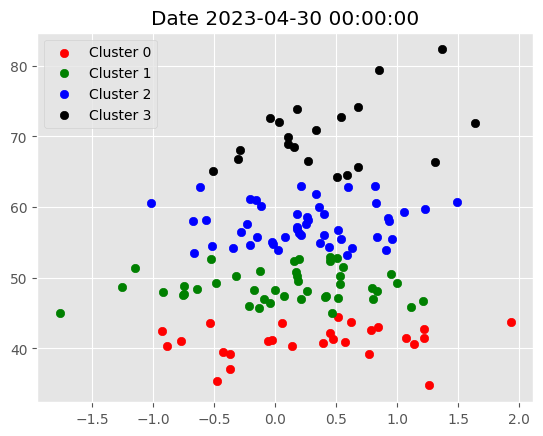

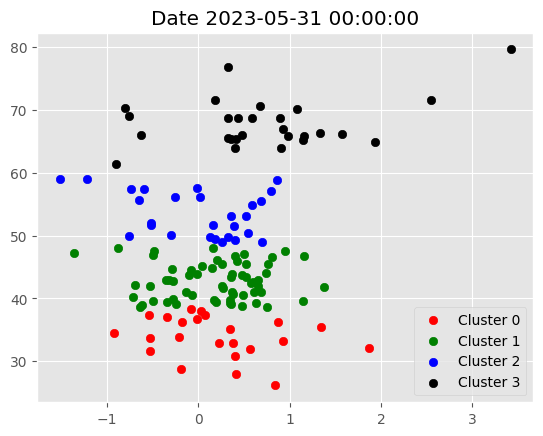

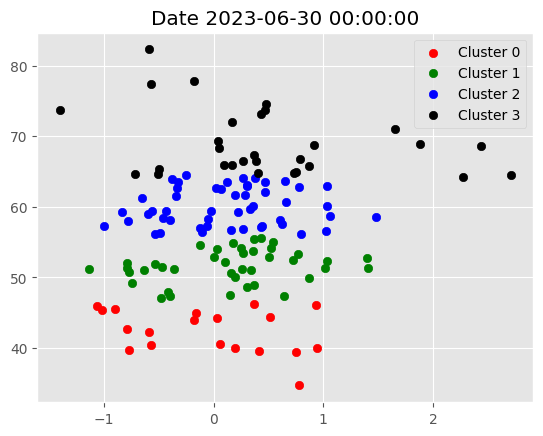

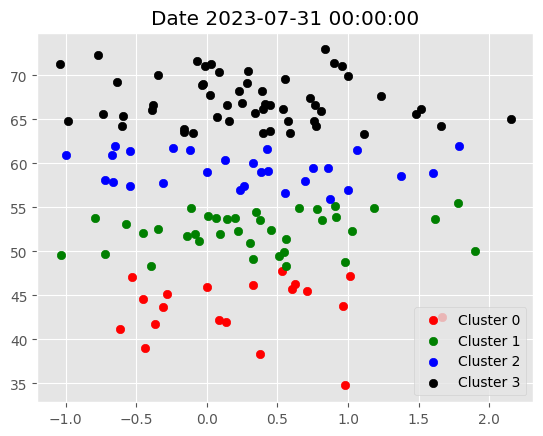

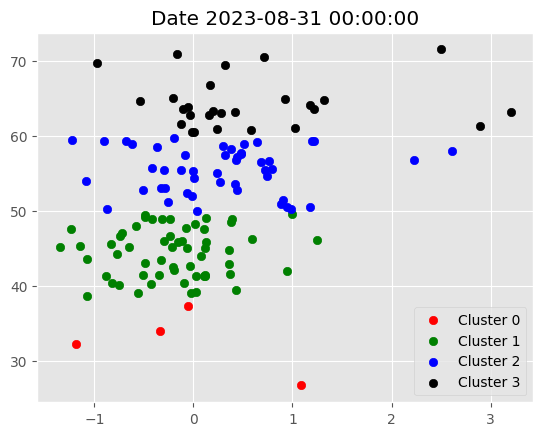

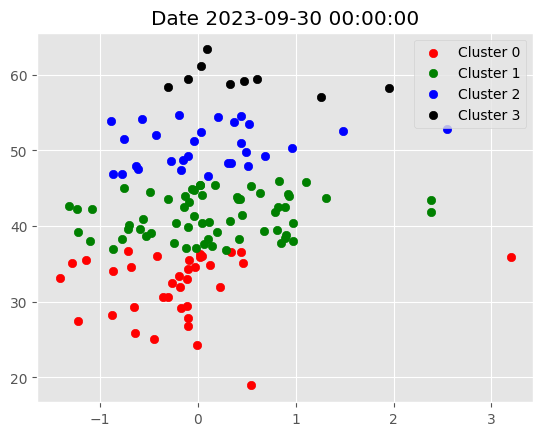

In [45]:
plt.style.use('ggplot')
for i in data.index.get_level_values('date').unique().tolist():
    g = data.xs(i, level=0)
    plt.title(f'Date {i}')
    plot_clusters(g)

In [47]:
filtered_df = data[data['cluster'] == 3].copy()
filtered_df = filtered_df.reset_index(level=1)
filtered_df.index = filtered_df.index + pd.DateOffset(1)
filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])
dates = filtered_df.index.get_level_values('date').unique().tolist()
fixed_dates = {}
for d in dates:
    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()
fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'LRCX',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BLK',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['ACN',
  'BA',
  'CAT',
  'CSCO',
  'CVX',
  'DE',
  'DG',
  'EOG',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'KR',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'PEP',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO',
  'WMT',
  'WYNN'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
 


### Define portfolio optimization function

- We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.

- To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.

- Apply single stock weight bounds constraint for diversification (minimum half of equally weight and maximum 10% of portfolio)

In [49]:
pip install PyPortfolioOpt

  Obtaining dependency information for PyPortfolioOpt from https://files.pythonhosted.org/packages/d4/9e/c8ffe7e9ba4ff0317fccd2e1dc466c47e64acea1b5e6b2f167d7d3097c93/pyportfolioopt-1.5.6-py3-none-any.whl.metadata
  Obtaining dependency information for cvxpy>=1.1.19 from https://files.pythonhosted.org/packages/17/5f/b3d48527032a684d62bb388853ed74ef17456d9ba140b7e5f2f4f9cede12/cvxpy-1.7.3-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for ecos<3.0.0,>=2.0.14 from https://files.pythonhosted.org/packages/56/9a/ca30572f3e3ff3cef6a0ea8aa6cdc12c36f9fefe559f65c7d6265713196a/ecos-2.0.14-cp312-cp312-win_amd64.whl.metadata
  Obtaining dependency information for plotly<6.0.0,>=5.0.0 from https://files.pythonhosted.org/packages/e5/ae/580600f441f6fc05218bd6c9d5794f4aef072a7d9093b291f1c50a9db8bc/plotly-5.24.1-py3-none-any.whl.metadata
  Obtaining dependency information for osqp>=1.0.0 from https://files.pythonhosted.org/packages/3b/d4/12f5ae735814466c490cb3e74ad9f38e0404f16bacc


[notice] A new release of pip is available: 23.2.1 -> 25.3
[notice] To update, run: C:\Users\duykh\AppData\Local\Programs\Python\Python312\python.exe -m pip install --upgrade pip


In [52]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound = 0):
    returns = expected_returns.mean_historical_return(prices= prices, frequency=252)
    cov = risk_models.sample_cov(prices=prices, frequency=252)
    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')
    weights = ef.max_sharpe()
    return ef.clean_weights()



- Download Fresh Daily Prices Data only for short listed stocks.
- Because we need data for the previous 12 months so we start from the 2016-10-30

In [53]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start= data.index.get_level_values('date').unique()[0] - pd.DateOffset(months=12),
                     end= data.index.get_level_values('date').unique()[-1])
new_df

[*********************100%***********************]  155 of 155 completed


Price            Close                                                 \
Ticker            AAPL        ABBV        ABT         ACN        ADBE   
Date                                                                    
2016-10-31   26.035645   38.226246  33.321095  101.253761  107.510002   
2016-11-01   25.565563   38.685410  33.159748  101.166641  106.870003   
2016-11-02   25.588491   38.918407  32.862530  103.318222  105.889999   
2016-11-03   25.314220   38.301628  32.590809  101.872215  107.169998   
2016-11-04   25.086031   38.404430  33.193699  102.116135  106.199997   
...                ...         ...        ...         ...         ...   
2023-09-25  174.203171  142.726974  93.269531  306.313019  511.600006   
2023-09-26  170.127075  142.044067  92.082977  300.147858  506.299988   
2023-09-27  168.613388  141.324219  91.413155  303.790955  502.600006   
2023-09-28  168.870590  140.512009  93.891533  290.639343  504.670013   
2023-09-29  169.385086  137.568008  92.676254  296.765808  509.899994   

Price                                                                  ...  \
Ticker             ADP        ADSK        AIG        AMAT         AMD  ...   
Date                                                                   ...   
2016-10-31   71.959038   72.279999  49.121162   26.281977    7.230000  ...   
2016-11-01   71.843323   70.099998  48.309109   26.119301    7.090000  ...   
2016-11-02   74.372574   68.680000  48.205620   25.839121    6.760000  ...   
2016-11-03   73.835327   67.610001  46.294910   25.549917    6.700000  ...   
2016-11-04   73.628677   69.440002  45.681885   25.504721    6.560000  ...   
...                ...         ...        ...         ...         ...  ...   
2023-09-25  229.862747  205.669998  59.545383  134.163177   97.379997  ...   
2023-09-26  227.200378  201.660004  58.711582  131.697784   95.959999  ...   
2023-09-27  232.362259  202.279999  58.471977  132.660355   98.070000  ...   
2023-09-28  233.013489  207.889999  58.730747  135.764236  102.760002  ...   
2023-09-29  230.399002  206.910004  58.079033  135.990128  102.820000  ...   

Price        Volume                                                           \
Ticker          VLO     VRTX        VZ     WDAY      WDC       WFC       WMT   
Date                                                                           
2016-10-31  4969500  1928200  12459400  1147300  4449514  20115900  19167000   
2016-11-01  7816800  2458200  13229400  1091400  5055315  20020200  26515800   
2016-11-02  7317600  2580400  16488200  1127800  5578033  19566600  22935900   
2016-11-03  3855900  2371000  12605100   633300  4223810  14982700  20411700   
2016-11-04  3729900  1902100  14410200   892600  3579509  27391600  21786300   
...             ...      ...       ...      ...      ...       ...       ...   
2023-09-25  3241900   698100  17616900   894200  3553446  10624000  10459500   
2023-09-26  4936800   633600  18841600  1217300  4724565  15219400  14435700   
2023-09-27  3644000   860600  22083500  2338100  3370739  11815500  15711000   
2023-09-28  3587300   578900  18772100  9196300  4342086  12454600  11617200   
2023-09-29  4302200   896800  19787600  4066600  3323376  13124500  18842400   

Price                                    
Ticker         WYNN       XOM       XYZ  
Date                                     
2016-10-31  1341600  16663800   2960600  
2016-11-01  3722300  13050600   8190900  
2016-11-02  2542400  11226100  19503200  
2016-11-03  9050400   8836500   7371500  
2016-11-04  3223800  13877100  13462800  
...             ...       ...       ...  
2023-09-25  1387800  11316000   8841300  
2023-09-26  1454000  11805400  10168200  
2023-09-27  2050000  23976200  11656100  
2023-09-28  1290400  16808100  16585100  
2023-09-29  1326800  18813600  11965300  

[1740 rows x 775 columns]

- Calculate daily returns for each stock which could land up in our portfolio.

- Then loop over each month start, select the stocks for the month and calculate their weights for the next month.

- If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.

- Calculated each day portfolio return.

In [ ]:
# Handle MultiIndex structure from yf.download()
# If new_df has MultiIndex columns, flatten it
if isinstance(new_df.columns, pd.MultiIndex):
    # Drop the first level (usually 'Close', 'Open', etc.) and keep ticker names
    new_df_close = new_df['Close'].copy()
else:
    new_df_close = new_df['Close'].copy()

# Calculate log returns
returns_dataframe = np.log(new_df_close).diff()

# Initialize portfolio returns dataframe
portfolio_returns_list = []

for start_date in fixed_dates.keys():
    try:
        # Calculate end date (end of month)
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        
        # Get tickers available for this date
        cols = fixed_dates[start_date]
        
        # Define optimization window (12 months before start_date, up to 1 day before)
        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')
        
        # Get price data for optimization (only available tickers)
        # Handle both MultiIndex and regular column structures
        try:
            optimization_df = new_df_close.loc[optimization_start_date:optimization_end_date, cols]
        except KeyError:
            # Try with date index as string
            optimization_df = new_df_close.loc[optimization_start_date:optimization_end_date][cols]
        
        # Filter out tickers that don't have enough data
        optimization_df = optimization_df.dropna(axis=1, how='any')
        
        if len(optimization_df.columns) == 0:
            print(f'No valid tickers for {start_date}, skipping...')
            continue
        
        # Try to optimize weights
        success = False
        weights_dict = {}
        
        try:
            weights_dict = optimize_weights(prices=optimization_df,
                                           lower_bound=round(1/(len(optimization_df.columns)*2), 3))
            success = True
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}: {e}, Using Equal-Weights')
        
        # If optimization failed, use equal weights
        if not success:
            equal_weight = 1.0 / len(optimization_df.columns)
            weights_dict = {ticker: equal_weight for ticker in optimization_df.columns}
        
        # Get returns for the holding period (start_date to end_date)
        try:
            period_returns = returns_dataframe.loc[start_date:end_date]
        except KeyError:
            period_returns = returns_dataframe[start_date:end_date]
        
        # Filter to only include tickers we have weights for
        available_tickers = [t for t in cols if t in period_returns.columns and t in weights_dict]
        period_returns = period_returns[available_tickers]
        
        if len(available_tickers) == 0:
            print(f'No matching tickers for {start_date}, skipping...')
            continue
        
        # Normalize weights to sum to 1 (in case some tickers were filtered out)
        total_weight = sum(weights_dict[t] for t in available_tickers)
        if total_weight > 0:
            weights_dict = {t: weights_dict[t] / total_weight for t in available_tickers}
        else:
            # If all weights are zero, use equal weights
            equal_weight = 1.0 / len(available_tickers)
            weights_dict = {t: equal_weight for t in available_tickers}
        
        # Calculate weighted portfolio returns for each day
        for date in period_returns.index:
            daily_returns = period_returns.loc[date, available_tickers]
            # Calculate portfolio return: sum of (weight * return) for each ticker
            portfolio_return = sum(weights_dict[ticker] * daily_returns[ticker] 
                                 for ticker in available_tickers 
                                 if not pd.isna(daily_returns[ticker]))
            
            portfolio_returns_list.append({
                'date': date,
                'Strategy Return': portfolio_return
            })
    
    except Exception as e:
        print(f'Error processing {start_date}: {e}')
        import traceback
        traceback.print_exc()
        continue

# Create final portfolio returns dataframe
if len(portfolio_returns_list) == 0:
    print("Warning: No portfolio returns were calculated. Check your data and fixed_dates.")
    portfolio_df = pd.DataFrame(columns=['Strategy Return'])
else:
    portfolio_df = pd.DataFrame(portfolio_returns_list)
    portfolio_df = portfolio_df.set_index('date')
    portfolio_df = portfolio_df.sort_index()
    portfolio_df = portfolio_df.drop_duplicates()
    
    print(f"Portfolio returns calculated for {len(portfolio_df)} days")
    print(f"Date range: {portfolio_df.index.min()} to {portfolio_df.index.max()}")

portfolio_df

Max Sharpe Optimization failed for 2018-05-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Using Equal-Weights
Max Sharpe Optimization failed for 2020-03-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Using Equal-Weights
Max Sharpe Optimization failed for 2020-04-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Using Equal-Weights
Max Sharpe Optimization failed for 2021-02-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Using Equal-Weights
Max Sharpe Optimization failed for 2021-10-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Using Equal-Weights
Max Sharpe Optimization failed for 2022-09-01: ('Please check your objectives/constraints or use a different solver.', 'Solver status: infeasible'), Using 

Strategy Return
date                       
2017-11-01         0.001107
2017-11-02         0.003219
2017-11-03         0.006337
2017-11-06         0.002696
2017-11-07         0.003129
...                     ...
2023-09-25         0.003440
2023-09-26        -0.012131
2023-09-27         0.005115
2023-09-28         0.006483
2023-09-29        -0.006803

[1487 rows x 1 columns]

In [85]:
# Download SPY data
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

# Handle MultiIndex structure from yf.download()
# If spy has MultiIndex columns, flatten it
if isinstance(spy.columns, pd.MultiIndex):
    # For single ticker, drop the first level and keep the column names
    spy_close = spy['Close'].copy()
    # If it's still a Series with MultiIndex, get the values
    if isinstance(spy_close, pd.Series):
        spy_close = spy_close.to_frame('Close')
    # Flatten MultiIndex columns if they exist
    if isinstance(spy_close.columns, pd.MultiIndex):
        spy_close.columns = spy_close.columns.droplevel(0)
else:
    spy_close = spy[['Close']].copy()

# Calculate log returns
spy_ret = np.log(spy_close).diff().dropna()

# Rename the column to 'SPY Buy&Hold'
# Get the actual column name (might be 'Close' or something else)
col_name = spy_ret.columns[0]
spy_ret = spy_ret.rename(columns={col_name: 'SPY Buy&Hold'})

# Ensure both DataFrames have the same index type (datetime)
if not isinstance(portfolio_df.index, pd.DatetimeIndex):
    portfolio_df.index = pd.to_datetime(portfolio_df.index)
if not isinstance(spy_ret.index, pd.DatetimeIndex):
    spy_ret.index = pd.to_datetime(spy_ret.index)

# Merge on index
portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True,
                                  how='left')

portfolio_df

[*********************100%***********************]  1 of 1 completed


Strategy Return  SPY Buy&Hold_x  SPY Buy&Hold_y
date                                                       
2017-11-01         0.001107        0.001321        0.001321
2017-11-02         0.003219        0.000388        0.000388
2017-11-03         0.006337        0.003333        0.003333
2017-11-06         0.002696        0.001547        0.001547
2017-11-07         0.003129       -0.000696       -0.000696
...                     ...             ...             ...
2023-09-25         0.003440        0.004196        0.004196
2023-09-26        -0.012131       -0.014800       -0.014800
2023-09-27         0.005115        0.000399        0.000399
2023-09-28         0.006483        0.005781        0.005781
2023-09-29        -0.006803       -0.002430       -0.002430

[1487 rows x 3 columns]

TypeError: 'locator' must be an instance of matplotlib.ticker.Locator, not a matplotlib.ticker.PercentFormatter

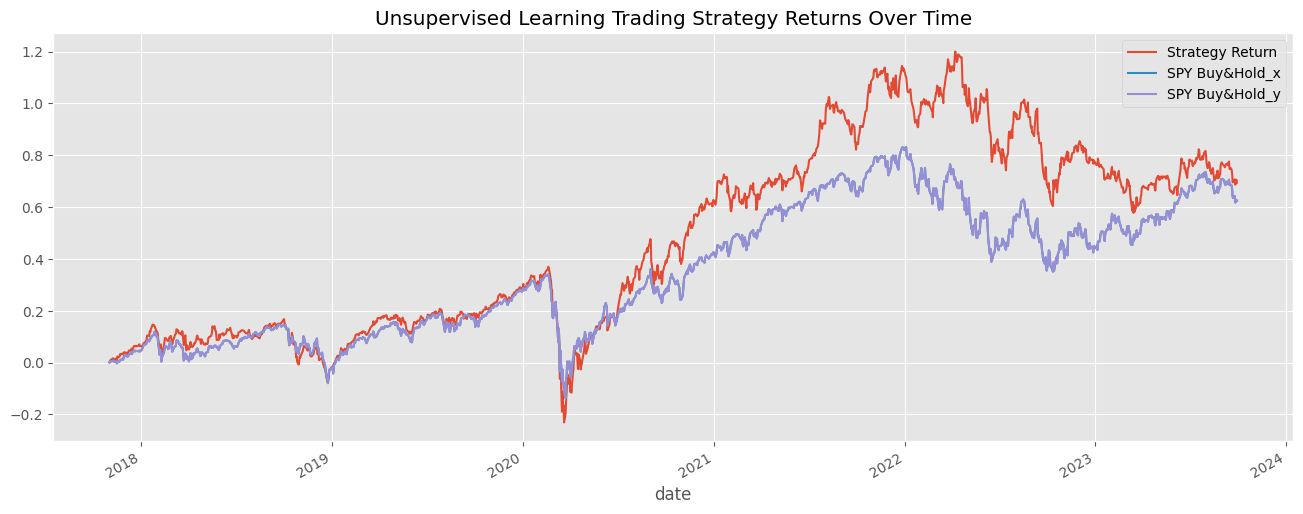

In [86]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df).cumsum())-1
portfolio_cumulative_return[:'2023-09-29'].plot(figsize=(16,6))
plt.title('Unsupervised Learning Trading Strategy Returns Over Time')
plt.gca().yaxis.set_major_locator(mtick.PercentFormatter(1))
plt.ylabel('Return')
plt.show()